In [71]:
# Tune hyperparameter here

embedding_size = 128
use_same_embedding = True
hidden_size = 128
wordset_path = '../data/word_set_0.pkl'
vocab_path = '../data/vocab_0.pkl'
trainset_path = '../data/train_0.pkl'
correct_trainset_path = '../data/correct_train_0.pkl'
validset_path = '../data/valid_0.pkl'
# correct_validset_path = '../data/correct_valid_0.pkl'
testset_path = '../data/test_0.pkl'
correct_testset_path = '../data/correct_test_0.pkl'
# testset_long_path = '../data/long_test_0.pkl'
saved_model_path = '../models/hn_128_word_0/model.pkl'

use_teacher_forcing = False

In [72]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import json
import numpy as np
from modules import *
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

from random import shuffle
import collections
import pdb

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

device = torch.device('cuda:0')

# Load data

In [73]:
# load vocab
with open(vocab_path, 'rb') as fin:
    word_dict = pickle.load(fin)
vocab_size = len(word_dict)
idx2word = {v:k for k,v in word_dict.items()}

with open(wordset_path, 'rb') as fin:
    wordset = pickle.load(fin)

# load trainset
with open(trainset_path, 'rb') as fin:
    trainset = pickle.load(fin)

# load corrent trainset
with open(correct_trainset_path, 'rb') as fin:
    correct_trainset = pickle.load(fin)

# load validset
# with open(validset_path, 'rb') as fin:
#     validset = pickle.load(fin)
    
# load correct validset
# with open(correct_validset_path, 'rb') as fin:
#     correct_validset = pickle.load(fin)

# load testset
with open(testset_path, 'rb') as fin:
    testset = pickle.load(fin)
    
# load correct testset
with open(correct_testset_path, 'rb') as fin:
    correct_testset = pickle.load(fin)

# load long testset
# with open(testset_long_path, 'rb') as fin:
#     testset_long = pickle.load(fin)

# Create and load model

In [74]:
encoder = EncoderRNN(vocab_size, hidden_size, embedding_size)
decoder = DecoderRNN(hidden_size, vocab_size, embedding_size, use_same_embedding)

saved_model = torch.load(saved_model_path)
encoder.load_state_dict(saved_model['encoder'])
decoder.load_state_dict(saved_model['decoder'])

encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.eval()
decoder.eval()

DecoderRNN(
  (gru): GRU(128, 128)
  (out): Linear(in_features=128, out_features=22213, bias=True)
  (softmax): LogSoftmax()
)

# Helper

In [75]:
def predict(batch):
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        encoder_hn = [None]
        
        for x in batch['sentence'][1:]:
            _, hn = encoder(x, encoder_hn[-1])
            encoder_hn.append(hn)
        
        encoder_hn.pop(0)
        encoder_hn = torch.stack(encoder_hn, dim=0).squeeze(1).transpose(0, 1) # batch, seq_len, dim
        
        idx = batch['sentence_len'].unsqueeze(1).repeat(1, hidden_size).view(batch_size, 1, hidden_size)
        decoder_hidden = torch.gather(encoder_hn, 1, idx).transpose(0, 1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        
        if use_teacher_forcing:
            pass
        
        else:
            
            _loss = 0
            _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
            
            for di in range(seq_len):
                if use_same_embedding:
                    decoder_input = encoder.get_embedding(decoder_input).detach()
#                     decoder_input = torch.zeros(decoder_input.shape).to(device)
                    
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
#                 decoder_output, decoder_hidden, _, _, _ = decoder2(decoder_input, decoder_hidden)
                
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
                decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

                _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])
                
                _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                     (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
        
        return _acc, _loss/seq_len, decoded_sentence

In [76]:
def predict2sentence(batch, pred):
    '''
    Args:
        batch: tensor (seq_len, batch_size)
        pred: list (seq_len, batch_size)
    '''
    _gt = batch.cpu().detach().numpy().transpose()
    _pd = np.array(pred).reshape(-1, batch.shape[1]).transpose()
    
    _ls = []
    for g, p in zip(_gt, _pd):
        s1 = ' '.join([idx2word[idx] for idx in g])
        s2 = ' '.join([idx2word[idx] for idx in p])
        _ls.append((s1, s2))
    
    return _ls

# Metrics

In [77]:
from metrics import Accuracy
metric = Accuracy()

# Dataset

In [78]:
# dataloaders = [DataLoader(dataset, 
#                          collate_fn=dataset.collate_fn, 
#                          batch_size=256, 
#                          shuffle=False, 
#                          num_workers=4) for dataset in [trainset, validset, testset, testset_long, correct_trainset, correct_testset]]

dataloaders = [DataLoader(dataset, 
                         collate_fn=dataset.collate_fn, 
                         batch_size=256, 
                         shuffle=False, 
                         num_workers=4) for dataset in [trainset, correct_testset]]

# Evaluation

In [79]:
def runtest(dataloaders, desc=['trainset', 'validset', 'testset', 'testset_long', 'correct trainset', 'correct testset']):
    
    sentences = []
    
    for dataloader, ds in zip(dataloaders, desc):
        # predict dataset
        metric.reset()
        loss = 0
        trange = tqdm(enumerate(dataloader),
                      total=len(dataloader),
                      desc='Evaluating {}'.format(ds))

        for i, batch in trange:

            _a, _l, _ = predict(batch)
            sentences += predict2sentence(batch['sentence'], _)
            loss += _l.item()
            metric.update(_a, batch)        
            trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
            
    return sentences

In [80]:
# sentences = runtest(dataloaders)

In [81]:
sentences = runtest([dataloaders[-1]], ['testset'])

# Wrong word analysis

In [30]:
wrong_ans = []
normal_count = {i:0 for i in range(1, 11)}
wrong_count = {i:0 for i in range(1, 11)}
for s1, s2 in sentences:
    s1 = [word for word in s1.split() if word != '<PAD>'][1:-1]
    s2 = s2.split()[1:len(s1)+1]
    
    normal_count[len(s1)] += 1
    
    if s1 != s2:
        wrong_ans.append((' '.join(s1), ' '.join(s2)))
        wrong_count[len(s1)] += 1

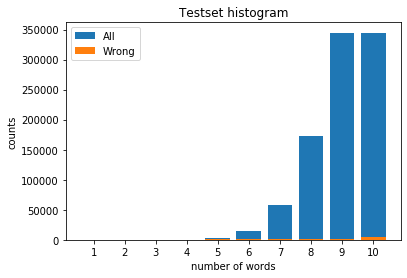

In [31]:
plt.title('Testset histogram')
plt.bar(range(len(normal_count)), list(normal_count.values()), label='All')
plt.bar(range(len(wrong_count)), list(wrong_count.values()), label='Wrong')
plt.xticks(range(len(wrong_count)), list(wrong_count.keys()))
plt.xlabel('number of words')
plt.ylabel('counts')
plt.legend()
plt.show()

In [32]:
wrong_word_count = {i:0 for i in range(1, 25)}
wrong_word_dict = collections.defaultdict(list)
for true, wrong in wrong_ans:
    wc = sum([1 for w1, w2 in zip(true.split(), wrong.split()) if w1 != w2])
    wrong_word_count[wc] += 1
    wrong_word_dict[wc].append((true, wrong))

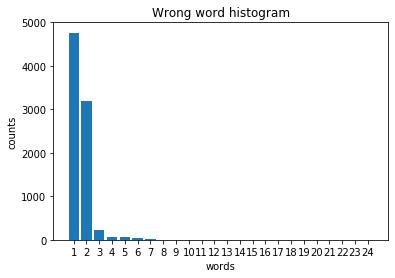

In [33]:
plt.title('Wrong word histogram')
plt.bar(range(len(wrong_word_count)), list(wrong_word_count.values()))
plt.xticks(range(len(wrong_word_count)), list(wrong_word_count.keys()))
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

In [34]:
wrong_word_dict[1][:10]

[("n't is . the a tom ? to i", "n't is . the . tom ? to i"),
 ("you tom to i a . ? is the n't", "you tom to i to . ? is the n't"),
 ("n't is tom a the", "n't is tom a you"),
 ('the . to you is tom a', 'the . to you is tom to'),
 ("i a . is tom to n't the ? you", 'i a . is tom to . the ? you'),
 ("is n't i to tom", "is n't ? to tom"),
 ("a tom is . to n't i you ? the", 'a tom is . to . i you ? the'),
 ("to is n't tom the .", "to is n't tom you ."),
 ("? i is . to tom n't a you the", '? i is . to tom . a you the'),
 ('is a . tom the', 'is a . tom you')]

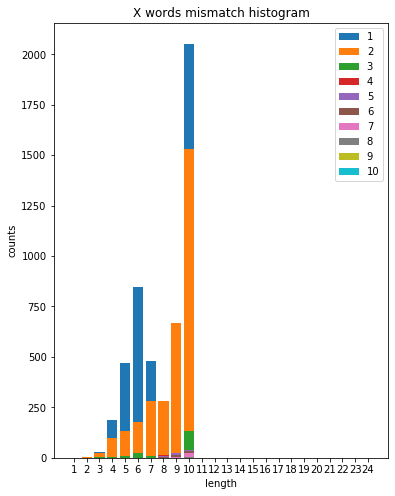

In [36]:
# X-word mismatch distribution
plt.figure(figsize=(6, 8))
plt.title('X words mismatch histogram')

for j in range(1, 11):
    tmp = {i:0 for i in range(1, 25)}
    for s1, s2 in wrong_word_dict[j]:
        tmp[len(s1.split())] += 1
    plt.bar(range(len(tmp)), list(tmp.values()), label=j)
plt.xticks(range(len(tmp)), list(tmp.keys()))
plt.xlabel('length')
plt.ylabel('counts')
plt.legend()
plt.show()

# Wrong sentence length analysis

In [37]:
wrong_sent_len = {i:0 for i in range(1, 25)}
wrong_sent_dict = collections.defaultdict(list)

for s1, s2 in sentences:
    _s1 = s1.split()
    s1idx = _s1.index('<EOS>')
    _s2 = s2.split()
    
    try:
        s2idx = _s2.index('<EOS>')
    except:
        s2idx = -1
    
    if s1idx != s2idx:
        wrong_sent_len[s1idx] += 1
        wrong_sent_dict[s1idx].append((s1, s2))

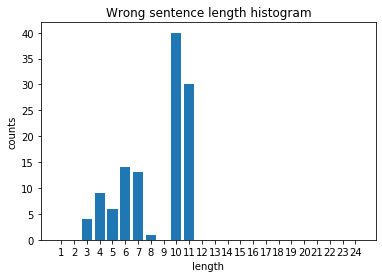

In [38]:
plt.title('Wrong sentence length histogram')
plt.bar(range(len(wrong_sent_len)), list(wrong_sent_len.values()))
plt.xticks(range(len(wrong_sent_len)), list(wrong_sent_len.keys()))
plt.xlabel('length')
plt.ylabel('counts')
plt.show()

In [39]:
wrong_sent_dict

defaultdict(list,
            {7: [('<SOS> you . a i tom to <EOS> <PAD> <PAD> <PAD> <PAD>',
               '<SOS> you . a i tom <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>'),
              ('<SOS> ? is a tom you to <EOS> <PAD> <PAD> <PAD> <PAD>',
               '<SOS> ? is a tom you <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>'),
              ("<SOS> n't the to i tom a <EOS> <PAD> <PAD> <PAD> <PAD>",
               "<SOS> n't the to i tom <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>"),
              ("<SOS> n't . to i tom a <EOS> <PAD> <PAD> <PAD> <PAD>",
               "<SOS> n't . to i tom <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>"),
              ("<SOS> the n't a i tom to <EOS> <PAD> <PAD> <PAD> <PAD>",
               "<SOS> the n't a i tom <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>"),
              ("<SOS> . a n't i tom to <EOS> <PAD> <PAD> <PAD> <PAD>",
               "<SOS> . a n't i tom <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>"),
              ('<SOS> is . a tom you to <EOS> <PAD> <PAD> <PAD> <PAD>',
               '<SO

In [40]:
for k, v in wrong_sent_dict.items():
    for s1, s2 in v:
        try:
            s2idx = s2.split().index('<EOS>')
            print(s1.split()[s2idx], wordset[s1.split()[s2idx]])
        except:
            print(s2)

to 7590496
to 7590496
a 7590491
a 7590491
to 7590496
to 7590496
to 7590496
to 7590496
to 7590496
to 7590496
a 7590491
to 7590496
to 7590496
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<PAD> 0
<SOS> tom tom the . i to i is a tom .
<SOS> tom tom the is i a ? n't a . tom
<SOS> tom tom n't a i a you n't you tom the
<SOS> tom tom you n't i a ? . is a tom
<SOS> tom tom the . i is n't you n't a tom
<SOS> to tom a . is you . the ? i is
<SOS> tom tom n't a i you is . the tom ?
<SOS> tom tom the . i to is n't you tom you
<SOS> tom tom the . i to the you is tom the
<SOS> tom tom n't is i a i . you a tom
<SOS> tom tom the . i is n't you a is tom
<SOS> tom tom n't . i is the a you tom ?
<SOS> tom tom n't a i a ? the is tom .
<SOS> . to

# Out-of-distribution testing data

In [ ]:
ood_sentences = runtest([dataloaders[3]], ['long_testset'])

In [ ]:
ood_right_dict = {i:0 for i in range(4, 25)}
ood_right_sent = {i:[] for i in range(4, 25)}
ood_wrong_dict = {'true':{i:0 for i in range(4, 25)}, 'false':{}}
ood_wrong_sent = {'true':{i:[] for i in range(4, 25)}, 'false':{}}
ood_distribution = {i:0 for i in range(4, 25)}

for ood_s1, ood_s2 in ood_sentences:
    _s1 = ood_s1.split()
    _s1idx = _s1.index('<EOS>') - 1
    _s2 = ood_s2.split()
    try:
        _s2idx = _s2.index('<EOS>') - 1
    except:
        _s2idx = -1
    
    if _s1idx not in ood_distribution:
        ood_distribution[_s1idx] = 0
    ood_distribution[_s1idx] += 1
    
    if _s1[1:_s1idx] == _s2[1:_s2idx]:
        if _s1idx not in ood_right_dict:
            ood_right_dict[_s1idx] = 0
        ood_right_dict[_s1idx] += 1
        ood_right_sent[_s1idx].append((ood_s1, ood_s2))
    else:
        if _s1idx not in ood_wrong_dict['true']:
            ood_wrong_dict['true'][_s1idx] = 0
        ood_wrong_dict['true'][_s1idx] += 1
        
        if _s1idx not in ood_wrong_sent['true']:
            ood_wrong_sent['true'][_s1idx] = []
        ood_wrong_sent['true'][_s1idx].append((ood_s1, ood_s2))
        
        if _s2idx not in ood_wrong_dict['false']:
            ood_wrong_dict['false'][_s2idx] = 0
        ood_wrong_dict['false'][_s2idx] += 1
        
        if _s2idx not in ood_wrong_sent['false']:
            ood_wrong_sent['false'][_s2idx] = []
        ood_wrong_sent['false'][_s2idx].append((ood_s1, ood_s2))

In [ ]:
plt.title('Long testset distribution')
plt.bar(range(len(ood_distribution)), list(ood_distribution.values()), label='All')
plt.bar(range(len(ood_right_dict)), list(ood_right_dict.values()), label='Correct')
plt.xticks(range(len(ood_distribution)), list(ood_distribution.keys()))
plt.xlabel('length')
plt.ylabel('counts')
plt.legend()
plt.show()

In [ ]:
plt.title('Wrong answer distribution')
plt.bar(range(len(normal_count)), [v*24.822883559664838 for v in normal_count.values()], label='Valid All (scaled)', color='C0')
plt.bar(range(len(wrong_count)), [v*24.822883559664838 for v in wrong_count.values()], label='Valid Wrong (scaled)', color='C1')
plt.bar(range(len(ood_distribution)), list(ood_distribution.values()), label='OOD All')
plt.bar(range(len(ood_wrong_dict['true'])), list(ood_wrong_dict['true'].values()), label='OOD Wrong', color='C2')
plt.xticks(range(len(ood_distribution)), list(ood_distribution.keys()))
plt.xlabel('length')
plt.ylabel('counts')
plt.legend()
plt.show()

In [ ]:
ood_wrong_dict['false'] = collections.OrderedDict(sorted(ood_wrong_dict['false'].items(), key = lambda x: x[0])) 

plt.title('Wrong answer predicted length')
plt.bar(range(len(ood_wrong_dict['false'])), list(ood_wrong_dict['false'].values()))
plt.xticks(range(len(ood_wrong_dict['false'])), list(ood_wrong_dict['false'].keys()))
plt.xlabel('length')
plt.ylabel('counts')
plt.show()

# Neuron Analysis

In [12]:
most_common2weight = collections.OrderedDict()
most_common2weight['<PAD>'] = word_dict['<PAD>']
most_common2weight['<UNK>'] = word_dict['<UNK>']
most_common2weight['<SOS>'] = word_dict['<SOS>']
most_common2weight['<EOS>'] = word_dict['<EOS>']
for word, _ in wordset.most_common():
    if word not in word_dict:
        most_common2weight['<UNK>'] = word_dict['<UNK>']
    else:
        most_common2weight[word] = word_dict[word]

weight = decoder.out.weight

for word, idx in most_common2weight.items():
    most_common2weight[word] = weight[idx].unsqueeze(1)

# get correct data from trainset/validation set

correct_indices = []

trange = tqdm(enumerate(dataloaders[0]),
              total=len(dataloaders[0]),
              desc='Evaluating {}'.format('training'))
loss = 0
metric.reset()

for i, batch in trange:

    _a, _l, _ = predict(batch)
    correct_indices += (_a.nonzero()+i*256).squeeze().tolist()

    loss += _l.item()
    metric.update(_a, batch)        
    trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
    
with open('../../pytorch_seq2seq/data/english_short_corpus_small_4to12_train.txt', 'r') as fin:
    tmp = fin.readlines()
    
with open('../data/english_short_corpus_small_4to12_correct_train.txt', 'w') as fout:
    for i in correct_indices:
        fout.write(tmp[i].strip() + '\n')
        


correct_indices = []

trange = tqdm(enumerate(dataloaders[2]),
              total=len(dataloaders[2]),
              desc='Evaluating {}'.format('testing'))
loss = 0
metric.reset()

for i, batch in trange:

    _a, _l, _ = predict(batch)
    correct_indices += (_a.nonzero()+i*256).squeeze().tolist()

    loss += _l.item()
    metric.update(_a, batch)        
    trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
    
with open('../../pytorch_seq2seq/data/english_short_corpus_small_4to12_test.txt', 'r') as fin:
    tmp = fin.readlines()
    
with open('../data/english_short_corpus_small_4to12_correct_test.txt', 'w') as fout:
    for i in correct_indices:
        fout.write(tmp[i].strip() + '\n')

In [13]:
def predictWithHidden(batch):
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        encoder_hn = [None]
        
        for x in batch['sentence'][1:]:
            _, hn = encoder(x, encoder_hn[-1])
            encoder_hn.append(hn)
        
        encoder_hn.pop(0)
        encoder_hn = torch.stack(encoder_hn, dim=0).squeeze(1).transpose(0, 1) # batch, seq_len, dim
        
        idx = batch['sentence_len'].unsqueeze(1).repeat(1, hidden_size).view(batch_size, 1, hidden_size)
        decoder_hidden = torch.gather(encoder_hn, 1, idx).transpose(0, 1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        
        _loss = 0
        _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
        
        hidden_dict = {}

        for di in range(seq_len):
            if use_same_embedding:
                decoder_input = encoder.get_embedding(decoder_input).detach()

            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            for _idx, _hidden in zip(decoder_input.squeeze(0), decoder_hidden.squeeze(0)):
                if _idx.data.item() not in hidden_dict:
                    hidden_dict[_idx.data.item()] = []
                hidden_dict[_idx.data.item()].append(_hidden)
            decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

            _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])

            _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                 (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
        
        return _acc, _loss/seq_len, decoded_sentence, hidden_dict

In [14]:
##### Train #####
most_common2hidden = collections.OrderedDict()
most_common2hidden['<PAD>'] = []
most_common2hidden['<UNK>'] = []
most_common2hidden['<SOS>'] = []
most_common2hidden['<EOS>'] = []
for word, _ in wordset.most_common():
    if word in word_dict:
        most_common2hidden[word] = []

trange = tqdm(enumerate(dataloaders[-2]),
              total=len(dataloaders[-2]),
              desc='Evaluating {}'.format('Correct Trainset'))

metric.reset()
loss = 0
sentences = []

for i, batch in trange:

    _a, _l, _, hd = predictWithHidden(batch)
    for k, v in hd.items():
        most_common2hidden[idx2word[k]] += v
    sentences += predict2sentence(batch['sentence'], _)

    loss += _l.item()
    metric.update(_a, batch)        
    trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
    
for k, v in most_common2hidden.items():
    if v:
        most_common2hidden[k] = torch.stack(v, dim=0)
        
_word_ls = []
for k, v in most_common2hidden.items():
    if k in ['<PAD>', '<SOS>', '<EOS>']:
        continue
        
    try:
        v.shape
        _word_ls.append(k)
    except:
        pass

IndexError: list index out of range

In [ ]:
trainset_idx_value_dict = {i:0 for i in range(16)}
for xword in tqdm(_word_ls, total=len(_word_ls)):
    ls = []
    for i in range(most_common2weight[xword].shape[0]):
        _weight = most_common2weight[xword].clone()
        _weight[i] = 0.0
        ls.append((i, torch.sum(torch.mm(most_common2hidden[xword], most_common2weight[xword]) - \
                                torch.mm(most_common2hidden[xword], _weight)).data.item()/most_common2hidden[xword].shape[0]))
    for i, v in ls:
        trainset_idx_value_dict[i] += abs(v)
### End Train ###

In [15]:
###### Test ######
most_common2hidden = collections.OrderedDict()
most_common2hidden['<PAD>'] = []
most_common2hidden['<UNK>'] = []
most_common2hidden['<SOS>'] = []
most_common2hidden['<EOS>'] = []
for word, _ in wordset.most_common():
    if word in word_dict:
        most_common2hidden[word] = []

trange = tqdm(enumerate(dataloaders[-1]),
              total=len(dataloaders[-1]),
              desc='Evaluating {}'.format('Correct Testset'))

metric.reset()
loss = 0

for i, batch in trange:

    _a, _l, _, hd = predictWithHidden(batch)
    for k, v in hd.items():
        most_common2hidden[idx2word[k]] += v
    sentences += predict2sentence(batch['sentence'], _)

    loss += _l.item()
    metric.update(_a, batch)        
    trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
    
for k, v in most_common2hidden.items():
    if v:
        most_common2hidden[k] = torch.stack(v, dim=0)
        
_word_ls = []
for k, v in most_common2hidden.items():
    if k in ['<PAD>', '<SOS>', '<EOS>']:
        continue
        
    try:
        v.shape
        _word_ls.append(k)
    except:
        pass

In [18]:
testset_idx_value_dict = {i:0 for i in range(16)}
for xword in tqdm(_word_ls, total=len(_word_ls)):
    ls = []
    for i in range(most_common2weight[xword].shape[0]):
        _weight = most_common2weight[xword].clone()
        _weight[i] = 0.0
        ls.append((i, torch.sum(torch.mm(most_common2hidden[xword], most_common2weight[xword]) - \
                                torch.mm(most_common2hidden[xword], _weight)).data.item()/most_common2hidden[xword].shape[0]))
    for i, v in ls:
        testset_idx_value_dict[i] += abs(v)
#### End Test ####

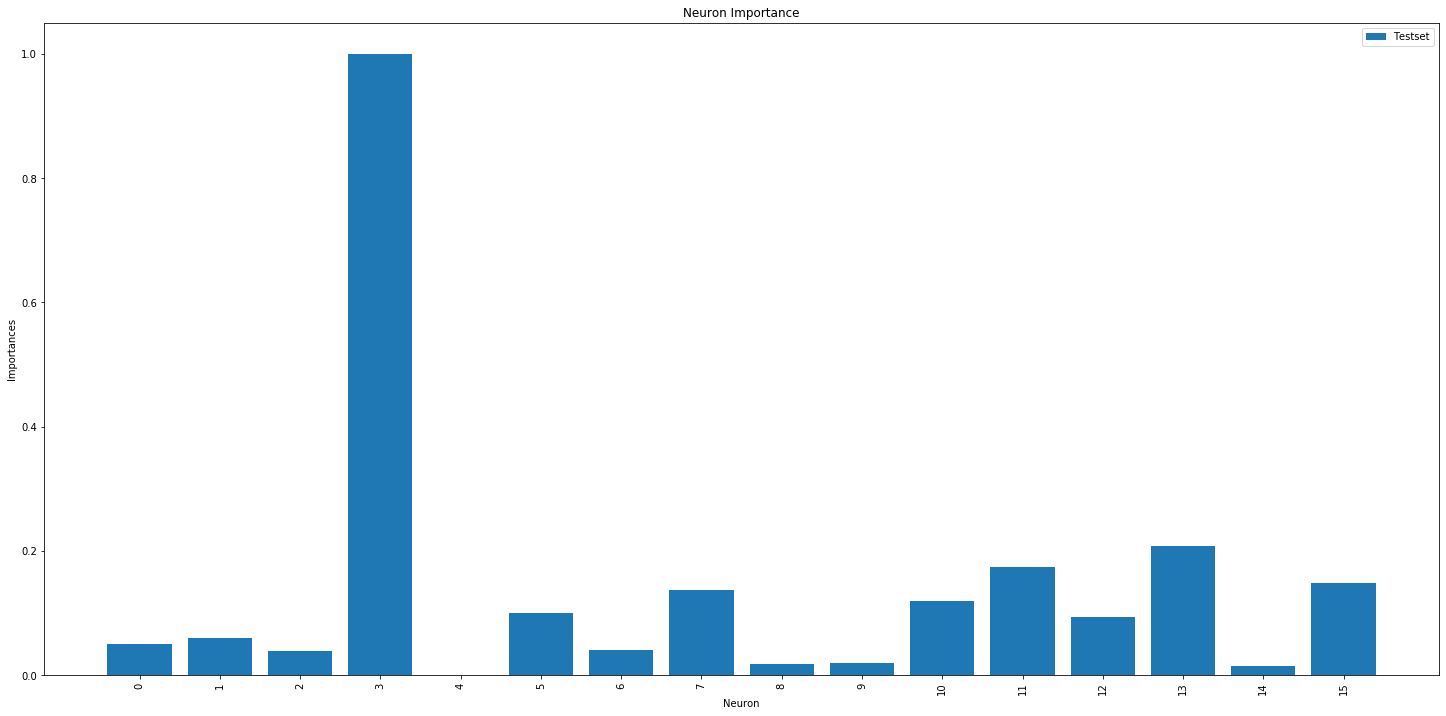

In [19]:
plt.figure(figsize=(25, 12))
plt.title('Neuron Importance')
# train_min = min(trainset_idx_value_dict.values())
# train_max = max(trainset_idx_value_dict.values())
# plt.bar(range(len(trainset_idx_value_dict)), [(i-train_min)/(train_max-train_min) for i in list(trainset_idx_value_dict.values())], label='Trainset')
test_min = min(testset_idx_value_dict.values())
test_max = max(testset_idx_value_dict.values())
plt.bar(range(len(testset_idx_value_dict)), [(i-test_min)/(test_max-test_min) for i in list(testset_idx_value_dict.values())], label='Testset')
plt.xticks(range(len(testset_idx_value_dict)), list(testset_idx_value_dict.keys()), rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Importances')
plt.legend()
plt.show()

In [ ]:
importance_trainset_idx = [(k, (v-train_min)/(train_max-train_min)) for k,v in trainset_idx_value_dict.items()]
# importance_testset_idx = [(k, (v-test_min)/(test_max-test_min)) for k,v in testset_idx_value_dict.items()]

In [ ]:
importance_trainset_idx = sorted(importance_trainset_idx, reverse=True, key=lambda x: x[1])
# importance_testset_idx = sorted(importance_testset_idx, reverse=True, key=lambda x: x[1])

## Ablation test (using value as importance)

In [20]:
def predictWithDiffModel(batch, encoder, decoder, use_teacher_forcing=False):
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        encoder_hn = [None]
        
        for x in batch['sentence'][1:]:
            _, hn = encoder(x, encoder_hn[-1])
            encoder_hn.append(hn)
        
        encoder_hn.pop(0)
        encoder_hn = torch.stack(encoder_hn, dim=0).squeeze(1).transpose(0, 1) # batch, seq_len, dim
        
        idx = batch['sentence_len'].unsqueeze(1).repeat(1, hidden_size).view(batch_size, 1, hidden_size)
        decoder_hidden = torch.gather(encoder_hn, 1, idx).transpose(0, 1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        
        if use_teacher_forcing:
            _loss = 0
            _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
            
            for di in range(seq_len):
                if use_same_embedding:
                    decoder_input = encoder.get_embedding(decoder_input).detach()
                    
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
                decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

                _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])
                
                _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                     (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
                
                decoder_input = batch['sentence'][di+1].unsqueeze(1)
        
        else:
            
            _loss = 0
            _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
            
            for di in range(seq_len):
                if use_same_embedding:
                    decoder_input = encoder.get_embedding(decoder_input).detach()
                    
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
                decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

                _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])
                
                _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                     (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
        
        return _acc, _loss/seq_len, decoded_sentence

In [ ]:
# set i-th neuron weight to Zero
neuron_acc = []
trange = tqdm(range(128), total=128, desc='Acc., Testset')
for n_idx in trange:
    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading
    
    # Removing i-th neuron
    
    decoder.out.weight[:, n_idx] = decoder.out.weight[:, n_idx] * 0.0
    
    # End Removing

    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
    
    neuron_acc.append((n_idx, float(metric.print_score())))

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Neuron Importance (Ablation test)')
plt.bar(range(len(testset_idx_value_dict)), [(i-test_min)/(test_max-test_min) for i in list(testset_idx_value_dict.values())], label='Testset')
ablation_min = min([i[1] for i in neuron_acc])
ablation_max = max([i[1] for i in neuron_acc])
plt.bar([i[0] for i in neuron_acc], [1.0-((i[1]-ablation_min)/(ablation_max-ablation_min)) for i in neuron_acc], label='Abalation Testset')
plt.xticks([i[0] for i in neuron_acc], [i[0] for i in neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Importances')
plt.legend()
plt.show()

In [ ]:
# Remove important neuron
most_important_neuron_acc = []
trange = tqdm(range(1, 129), total=128, desc='Most important, Testset')
for thrsh in trange:
    important_nuerons = [n[0] for n in importance_trainset_idx[:thrsh]]

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing
    
    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
        
    most_important_neuron_acc.append((important_nuerons[-1], float(metric.print_score())))
    

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (from most important neuron)')
plt.bar([str(i[0]) for i in most_important_neuron_acc], [i[1] for i in most_important_neuron_acc], label='Testset')
plt.xticks([str(i[0]) for i in most_important_neuron_acc], [i[0] for i in most_important_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Remove unimportant neuron
most_unimportant_neuron_acc = []
trange = tqdm(range(1, 129), total=128, desc='Most unimportant, Testset')
for thrsh in trange:
    important_nuerons = [n[0] for n in importance_trainset_idx[::-1][:thrsh]]

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing
    
    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
        
    most_unimportant_neuron_acc.append((important_nuerons[-1], float(metric.print_score())))
    

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (from most unimportant neuron)')
plt.bar([str(i[0]) for i in most_unimportant_neuron_acc], [i[1] for i in most_unimportant_neuron_acc], label='Testset')
plt.xticks([str(i[0]) for i in most_unimportant_neuron_acc], [i[0] for i in most_unimportant_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Remove neuron not including most important 40 neurons
unimportant_neuron_acc = []
trange = tqdm(range(1, 89), total=88, desc='Most important w/0 40, Testset')
for thrsh in trange:
    important_nuerons = [n[0] for n in importance_trainset_idx[40:40+thrsh]]

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing

    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
        
    unimportant_neuron_acc.append((important_nuerons[-1], float(metric.print_score())))
    

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (without most important 44 neurons)')
plt.bar([str(i[0]) for i in unimportant_neuron_acc], [i[1] for i in unimportant_neuron_acc], label='Testset')
plt.xticks([str(i[0]) for i in unimportant_neuron_acc], [i[0] for i in unimportant_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Remove important neuron
def predictWithImpNeuron(imp_neurons):
    important_nuerons = list(imp_neurons)
    
    global encoder
    global decoder

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing

    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
#         trange.set_postfix(accuracy=metric.print_score())
        
    return float(metric.print_score())

In [ ]:
# # Greedy
# value_candidates = [i[0] for i in neuron_acc_ls]
# value_bestset_2 = []

# while value_candidates:
#     _ls = []
#     print(len(value_candidates))
#     for i in value_candidates:
#         _ls.append((i, predictWithImpNeuron(value_bestset_2 + [i])))
#     _min = min(_ls, key=lambda x: x[1])
#     value_bestset_2 += [_min[0]]
#     value_candidates.remove(_min[0])
#     if _min[1] == 0.0:
#         break

In [ ]:
# value_bestset = {0, 2, 5, 70, 71, 74, 12, 13, 78, 77, 
#                  81, 83, 20, 19, 87, 27, 96, 34, 98, 
#                  35, 41, 43, 44, 109, 110, 45, 48, 
#                  111, 114, 51, 124, 127, 119, 60, 62, 63}
# predictWithImpNeuron(value_bestset_2)

value_bestset_2 = [70, 110, 20, 5, 13, 34, 71, 83, 41, 12, 63, 109, 
                   48, 119, 98, 19, 27, 114, 81, 87, 45, 78, 77, 111, 
                   44, 62, 60, 51, 2, 124, 127, 96, 74, 0, 10, 32]

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (greedy search)')
barlist = plt.bar([str(i[0]) for i in most_important_neuron_acc], [i[1]+1.0 for i in most_important_neuron_acc], label='Testset')
for i in list(value_bestset_2):
    barlist[i].set_color('r')
plt.xticks([str(i[0]) for i in most_important_neuron_acc], [i[0] for i in most_important_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy (1.0~2.0)')
plt.legend()
plt.show()

v1: {0, 2, 5, 70, 71, 74, 12, 13, 78, 77, 81, 83, 20, 19, 87, 27, 96, 34, 98, 35, 41, 43, 44, 109, 110, 45, 48, 111, 114, 51, 124, 127, 119, 60, 62, 63}

v2: [70, 110, 20, 5, 13, 34, 71, 83, 41, 12, 63, 109, 48, 119, 98, 19, 27, 114, 81, 87, 45, 78, 77, 111, 44, 62, 60, 51, 2, 124, 127, 96, 74, 0, 10, 32]

In [ ]:
# Remove most important from greedy
greedy_important_neuron_acc = []
trange = tqdm(range(1, 38), total=37, desc='Most important greedy, Testset')
for thrsh in trange:
    important_nuerons = [n for n in list(value_bestset_2)[:thrsh]]

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing
    
    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
        
    greedy_important_neuron_acc.append((important_nuerons[-1], float(metric.print_score())))

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (greedy search)')
plt.bar([str(i[0]) for i in greedy_important_neuron_acc], [i[1] for i in greedy_important_neuron_acc], label='Testset')
plt.xticks([str(i[0]) for i in greedy_important_neuron_acc], [i[0] for i in greedy_important_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# # DP
# dp = {}
# max_len = 46

# def smallest_set(cands, s):
#     global dp
#     global max_len
    
#     if cands == []:
#         if s in dp:
#             return dp[s]
#         else:
#             dp[s] = predictWithImpNeuron(s)
#             return dp[s]
#     else:
#         if s in dp and s != frozenset():
#             return dp[s]
#         else:
#             tmp = predictWithImpNeuron(s)
#             dp[s] = tmp
#             print(s, tmp, max_len)
#             if tmp == 0.0:
#                 if len(s) < max_len:
#                     max_len = len(s)
#                 return dp[s]
#             _ls = [(s, tmp)]
#             for i in range(len(cands)):
#                 _currset = s | frozenset([cands[i]])
#                 tmp = smallest_set(cands[i+1:], _currset)
#                 if _currset not in dp:
#                     dp[_currset] = tmp
#                 if len(_currset) >= max_len:
#                     return tmp
#                 _ls.append((_currset, tmp))
#             _min = min(_ls, key=lambda x: x[1])
#             dp[_min[0]] = _min[1]
            
#             return dp[_min[0]]

# value_candidates = [i[0] for i in most_important_neuron_acc]
# smallest_set(value_candidates, frozenset([]))

## Ablation test (by using accuracy as importance)

In [ ]:
neuron_acc_ls = [(i[0], 1.0-((i[1]-ablation_min)/(ablation_max-ablation_min))) for i in neuron_acc]
neuron_acc_ls = sorted(neuron_acc_ls, reverse=True, key=lambda x: x[1])

In [ ]:
# Remove important neuron
most_important_acc_neuron_acc = []
trange = tqdm(range(1, 129), total=128, desc='Most important acc., Testset')
for thrsh in trange:
    important_nuerons = [n[0] for n in neuron_acc_ls[:thrsh]]

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing

    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
        
    most_important_acc_neuron_acc.append((important_nuerons[-1], float(metric.print_score())))
    

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (from most important acc. neuron)')
plt.bar([str(i[0]) for i in most_important_acc_neuron_acc], [i[1] for i in most_important_acc_neuron_acc], label='Testset')
plt.xticks([str(i[0]) for i in most_important_acc_neuron_acc], [i[0] for i in most_important_acc_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (greedy search)')
barlist = plt.bar([str(i[0]) for i in most_important_acc_neuron_acc], [i[1]+1.0 for i in most_important_acc_neuron_acc], label='Testset')
for i in list(value_bestset_2):
    barlist[i].set_color('r')
plt.xticks([str(i[0]) for i in most_important_acc_neuron_acc], [i[0] for i in most_important_acc_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy (1.0~2.0)')
plt.legend()
plt.show()

In [ ]:
# Remove unimportant neuron
most_unimportant_acc_neuron_acc = []
trange = tqdm(range(1, 129), total=128, desc='Most unimportant acc., Testset')
for thrsh in trange:
    important_nuerons = [n[0] for n in neuron_acc_ls[::-1][:thrsh]]

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing

    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
        
    most_unimportant_acc_neuron_acc.append((important_nuerons[-1], float(metric.print_score())))
    

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (from most unimportant acc. neuron)')
plt.bar([str(i[0]) for i in most_unimportant_acc_neuron_acc], [i[1] for i in most_unimportant_acc_neuron_acc], label='Testset')
plt.xticks([str(i[0]) for i in most_unimportant_acc_neuron_acc], [i[0] for i in most_unimportant_acc_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Remove neuron not including most important 50 neurons
unimportant_acc_neuron_acc = []
trange = tqdm(range(1, 77), total=76, desc='Most important acc. w/o 52, Testset')
for thrsh in trange:
    important_nuerons = [n[0] for n in neuron_acc_ls[52:52+thrsh]]

    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron

    decoder.out.weight[:, important_nuerons] = decoder.out.weight[:, important_nuerons] * 0.0

    # End Removing

    metric.reset()
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _ = predictWithDiffModel(batch, encoder, decoder)

        loss += _l.item()
        metric.update(_a, batch)        
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score())
        
    unimportant_acc_neuron_acc.append((important_nuerons[-1], float(metric.print_score())))
    

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Elimination test (without most important 53 neurons)')
plt.bar([str(i[0]) for i in unimportant_acc_neuron_acc], [i[1] for i in unimportant_acc_neuron_acc], label='Testset')
plt.xticks([str(i[0]) for i in unimportant_acc_neuron_acc], [i[0] for i in unimportant_acc_neuron_acc], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Word Accuracy analysis

In [82]:
from metrics import Metrics

class WordAccuracy(Metrics):
    """
    Accuracy a.k.a Micro F1 score
    """
    class Word():
        def __init__(self):
            # n_predict is the number of word appear
            # n_correct is the number of word that doesnt appear
            # n is the number of word in dataset
            
            self.n_predict = 0
            self.n_correct = 0
            self.n = 0
        
        def get_score(self):
            return self.n_correct / self.n
        
        def get_predict_rate(self):
            return self.n_predict / self.n
    
    def __init__(self, dataloader):
        # word_dict[word] = Word()
        self.reset(dataloader)      
        self.name = 'Word Acc.'

    def reset(self, dataloader, verbose=True):
        self.word_dict = {}
        
        if verbose:
            trange = tqdm(dataloader, total=len(dataloader))
        else:
            trange = dataloader
            
        for datas in trange:
            for data in datas['sentence']:
                for idx in data[1:]:
                    word = idx2word[idx.item()]
                    if word == '<PAD>':
                        break
                    if word not in self.word_dict:
                        self.word_dict[word] = self.Word()
                    self.word_dict[word].n += 1

    def update(self, logits, batch):
        """
        Args:
            logits (batch_size, sequence_length, 1)
            batch ['sentence', 'sentence_len'] (sequence_length, batch_size)
            ** sequence_length = <SOS> + sentence_len + <EOS> + n*<PAD>
        """
        for pred, ground, len in zip(logits.transpose(), 
                                     batch['sentence'].cpu().detach().numpy().transpose(), 
                                     batch['sentence_len'].cpu().detach().numpy()):
            for idx in range(1, len+2):
                # n_correct +1
                _word = idx2word[pred[idx]]
                if _word not in self.word_dict:
                    self.word_dict[_word] = self.Word()
                    self.word_dict[_word].n += 1
                    
                if _word == idx2word[ground[idx]]:  
                    self.word_dict[_word].n_correct += 1

                # n_predict +1
                self.word_dict[_word].n_predict += 1

    def get_score_dict(self):
        # Return word dictionary
        return self.word_dict
    
    def get_word(self, word):
        return self.word_dict[word]

    def print_score(self):
        # Print avg. accuracy
        score = [v.get_score() for k, v in self.word_dict.items()]
        return '{:.5f}'.format(sum(score)/len(score))
    
word_metric = WordAccuracy(dataloaders[-1])

In [22]:
# set i-th neuron weight to Zero
neuron_impact_dict = {}
trange = tqdm(range(16), total=16, desc='Acc., Testset')
for n_idx in trange:
    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading
    
    # Removing i-th neuron
    
    decoder.out.weight[:, n_idx] = decoder.out.weight[:, n_idx] * 0.0
    
    # End Removing

    metric.reset()
    word_metric.reset(dataloaders[-1], verbose=False)
    loss = 0

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _s = predictWithDiffModel(batch, encoder, decoder)
        _s = np.stack(_s)
        
        loss += _l.item()
        metric.update(_a, batch)
        word_metric.update(_s, batch)
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score(), w_acc=word_metric.print_score())
    
    neuron_impact_dict[n_idx] = (sorted([(k, v.n, v.get_score(), v.get_predict_rate()) for k, v in word_metric.get_score_dict().items() if v.get_score() < 1.0], 
                                        key=lambda x: (x[1], x[2], x[0])), 
                                float(word_metric.print_score()))

In [238]:
# Loading new encoder and decoder
saved_model = torch.load(saved_model_path)
decoder.load_state_dict(saved_model['decoder'])

decoder = decoder.to(device)

encoder.eval()
decoder.eval()
# End Loading

# Removing i-th neuron

decoder.out.weight[:, [10]] = decoder.out.weight[:, [10]] * 0.0

# End Removing

metric.reset()
word_metric.reset(dataloaders[-1], verbose=False)
loss = 0

for i, batch in enumerate(dataloaders[-1]):

    _a, _l, _s = predictWithDiffModel(batch, encoder, decoder)
    _s = np.stack(_s)

    loss += _l.item()
    metric.update(_a, batch)
    word_metric.update(_s, batch)
    trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score(), w_acc=word_metric.print_score())

neuron_dict = (sorted([(k, v.n, v.get_score(), v.get_predict_rate()) for k, v in word_metric.get_score_dict().items() if v.get_score() < 1.0], 
                                    key=lambda x: (x[1], x[2], x[0])), 
                            float(word_metric.print_score()))

In [239]:
word_metric.print_score()

'0.89124'

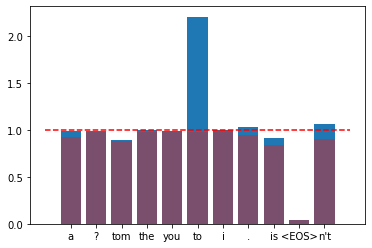

In [170]:
plt.figure(figsize=(6, 4))

plt.bar([k for k, v in word_metric.word_dict.items()], [v.get_predict_rate() for k, v in word_metric.word_dict.items()], label='Predict rate', color='C0')
plt.bar([k for k, v in word_metric.word_dict.items()], [v.get_score() for k, v in word_metric.word_dict.items()], label='Accuracy', alpha=0.5, color='C3')
plt.hlines(y=1.0, xmin=-1, xmax=len(_neuron_impaction), colors='r', linestyles='dashed')

plt.show()

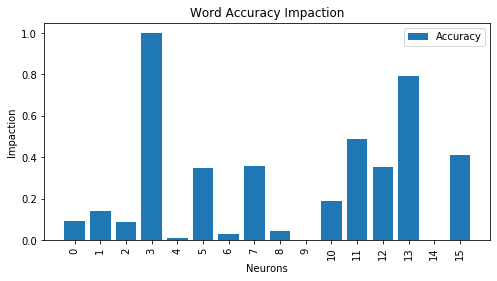

In [27]:
plt.figure(figsize=(8, 4))
plt.title('Word Accuracy Impaction')
min_word_neuron = min([v[1] for k, v in neuron_impact_dict.items()])
max_word_neuron = max([v[1] for k, v in neuron_impact_dict.items()])
plt.bar([k for k, v in neuron_impact_dict.items()], [1.0 - (v[1]-min_word_neuron)/(max_word_neuron-min_word_neuron) for k, v in neuron_impact_dict.items()], label='Accuracy')
plt.xticks([k for k, v in neuron_impact_dict.items()], [k for k, v in neuron_impact_dict.items()], rotation='vertical')
plt.xlabel('Neurons')
plt.ylabel('Impaction')
plt.legend()
plt.show()

In [28]:
neuron_impact_dict[3][0]

[('?', 843020, 0.0, 0.003257336717990083),
 ('i', 843028, 0.0, 0.0),
 ('you', 843077, 0.9456313005810857, 1.113987215877079),
 ('tom', 843206, 0.9983503438068515, 1.0367656302255914),
 ('.', 843410, 0.5180789888666247, 0.5962793896207064),
 ('to', 843458, 0.0, 0.0),
 ("n't", 843505, 0.1426832087539493, 0.8363459611976218),
 ('a', 843575, 0.003187624099813295, 0.16145926562546306),
 ('the', 843753, 0.8372142084235552, 5.497809192974722),
 ('is', 843775, 0.3856122781547213, 0.6304998370418654),
 ('<EOS>', 937089, 0.9916347326668011, 1.1091795976689514)]

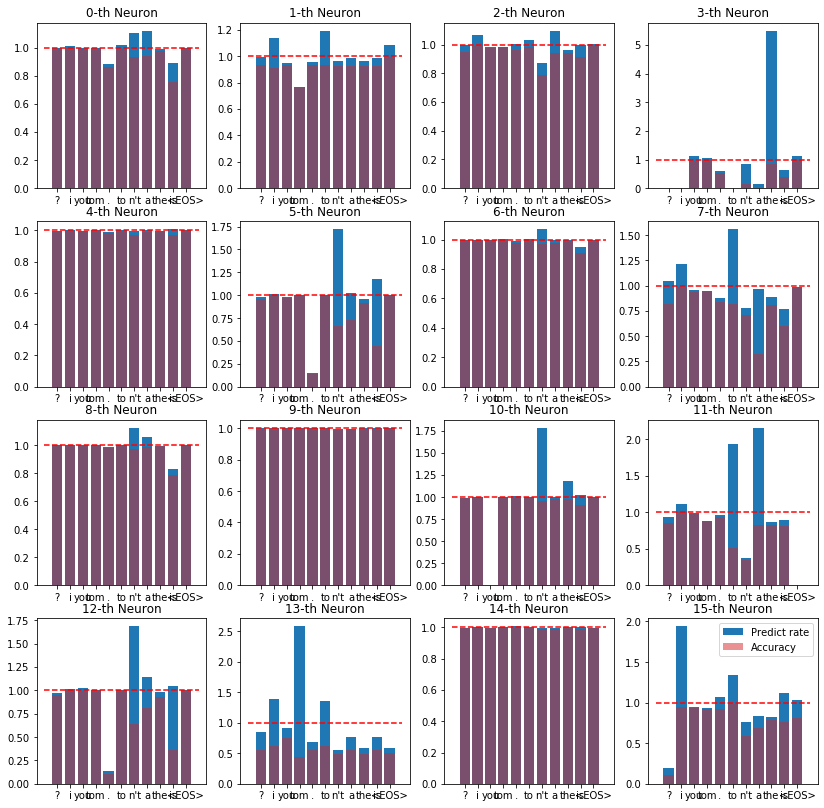

In [120]:
plt.figure(figsize=(14, 14))

for idx, (k, v) in enumerate(neuron_impact_dict.items()):
    _neuron_impaction = v[0]
    plt.subplot(4,4,idx+1)
    plt.title('{}-th Neuron'.format(k))
    plt.bar([i[0] for i in _neuron_impaction], [i[3] for i in _neuron_impaction], label='Predict rate', color='C0')
    plt.bar([i[0] for i in _neuron_impaction], [i[2] for i in _neuron_impaction], label='Accuracy', alpha=0.5, color='C3')
    plt.hlines(y=1.0, xmin=-1, xmax=len(_neuron_impaction), colors='r', linestyles='dashed')
# plt.xticks([i[0] for i in _neuron_impaction], [i[0] for i in _neuron_impaction], rotation='vertical')
# plt.xlabel('Words')
# plt.ylabel('Value')
plt.legend()
plt.show()

In [157]:
word_neuron_dict = {}
for idx, (k, v) in enumerate(neuron_impact_dict.items()):
    for datas in v[0]:
        if datas[2] <= 0.9 or datas[3] > 1.1:
            if datas[0] not in word_neuron_dict:
                word_neuron_dict[datas[0]] = []
            word_neuron_dict[datas[0]].append(k)

In [168]:
set([_v for k,v in word_neuron_dict.items() for _v in v])

{0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 15}

In [159]:
word_neuron_dict

{'.': [0, 3, 5, 7, 12, 13],
 "n't": [0, 2, 3, 5, 7, 8, 10, 11, 12, 13, 15],
 'a': [0, 3, 5, 7, 11, 12, 13, 15],
 'is': [0, 3, 5, 7, 8, 11, 12, 13, 15],
 'i': [1, 3, 7, 11, 13, 15],
 'tom': [1, 11, 13],
 'to': [1, 3, 7, 11, 13, 15],
 '?': [3, 7, 11, 13, 15],
 'you': [3, 10, 13],
 'the': [3, 7, 10, 11, 13, 15],
 '<EOS>': [3, 11, 13, 15]}

In [30]:
word2neuron_impaction = {}
for k, v in neuron_impact_dict.items():
    for (w, _,_,_) in v[0]:
        if w not in word2neuron_impaction:
            word2neuron_impaction[w] = set()
        word2neuron_impaction[w] |= {k}

In [31]:
def setNeuron2Zero(neurons, dataloader):
    global decoder
    global encoder
    
    neurons = list(neurons)
    
    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading
    
    # Removing i-th neuron
    
    decoder.out.weight[:, neurons] = decoder.out.weight[:, neurons] * 0.0
    
    # End Removing

    metric.reset()
    word_metric.reset(dataloader, verbose=False)
    loss = 0
    
    trange = tqdm(enumerate(dataloader),
                  total=len(dataloader),
                  desc='Evaluating {}'.format(neurons))

    for i, batch in trange:

        _a, _l, _s = predictWithDiffModel(batch, encoder, decoder, True)
        _s = np.stack(_s)
        
        loss += _l.item()
        metric.update(_a, batch)
        word_metric.update(_s, batch)
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score(), w_acc=word_metric.print_score())
        
    return word_metric.get_score_dict()

In [129]:
_x = []
for (n_idx, acc) in most_important_acc_neuron_acc:
    _x.append(n_idx)
    if acc == 0.0:
        break
print(len(_x))

NameError: name 'most_important_acc_neuron_acc' is not defined

In [ ]:
# from itertools import compress, product
# def combinations(items):
#     p = list(product(*[[0,1]]*len(items)))
#     return (set(compress(items, mask)) for mask in tqdm(p, total=len(p)))

# tmp_c = list(combinations(range(128)))

In [ ]:
tmmp = setNeuron2Zero(_x, dataloaders[-1])

In [ ]:
xword = '.'
print(tmmp[xword].get_predict_rate())
print(tmmp[xword].get_score())
print(tmmp[xword].n_predict, tmmp[xword].n_correct, tmmp[xword].n)

In [23]:
counter = 0
curr_v = 0
ranking = {}
for idx, (w, v) in enumerate(wordset.most_common()):
    if curr_v != v:
        counter += 1
        curr_v = v
    ranking[counter] = idx+1

In [24]:
top5 = int(len({v for (w, v) in wordset.most_common()})*0.05)
top10 = int(len({v for (w, v) in wordset.most_common()})*0.1)
top20 = int(len({v for (w, v) in wordset.most_common()})*0.2)
top50 = int(len({v for (w, v) in wordset.most_common()})*0.5)
top75 = int(len({v for (w, v) in wordset.most_common()})*0.75)
top90 = int(len({v for (w, v) in wordset.most_common()})*0.9)
top95 = int(len({v for (w, v) in wordset.most_common()})*0.95)

In [135]:
most_common_word = [(w, tmmp[w].get_score(), tmmp[w].get_predict_rate()) for (w, v) in wordset.most_common(ranking[top20]) if w in tmmp]
print(len(most_common_word))

NameError: name 'tmmp' is not defined

In [ ]:
plt.figure(figsize=(20, 8))
plt.title('Most common word')
plt.bar([i[0] for i in most_common_word], [i[2] for i in most_common_word], label='predict rate', color='C1')
plt.bar([i[0] for i in most_common_word], [i[1] for i in most_common_word], label='Accuracy')
plt.xticks([i[0] for i in most_common_word], [i[0] for i in most_common_word], rotation='vertical')
plt.axhline(y=1.0, color='r', linestyle='-')
plt.xlabel('Neuron')
plt.ylabel('Value')
plt.legend()
plt.show()

# Integrated Gradient

In [57]:
def IntegratedGradient(hiddens, word, steps=10, _r=None):
    
    def update(_x, _w, _b, _y_hat):
        _a = _x@_w.transpose(1, 0) + _b
        _a = nn.Softmax(dim=1)(_a)
        _a = _a.gather(1, _y_hat).sum()
        
        _a.backward()
        
        with torch.no_grad():
            try:
                _h = _x.grad.clone().numpy()
            except:
                _h = _x.grad.clone().cpu().numpy()
                
        return _h
    
    device = 'cuda'
    _h = [0.0 for i in range(hiddens.shape[1])]

    _y_hat = [torch.tensor([word_dict[word]]).requires_grad_(False).long().to(device) for i in range(steps + 1)]
    _y_hat = torch.stack(_y_hat, dim=0)
    _w = decoder.out.weight.clone().detach().cpu().to(device)
    _b = decoder.out.bias.clone().detach().cpu().to(device)
    
    _ig = np.array(_h)
    
    trange = tqdm(hiddens,
                  total=len(hiddens),
                  desc='Evaluating {}, size of {}'.format(word_dict[word], hiddens.shape[0]))
    
    for hidden in trange:
        _base = torch.zeros(hidden.shape)
        _hiddens = [_base + float(i/steps)*hidden.cpu() for i in range(steps + 1)]
        _hiddens = nn.Parameter(torch.stack(_hiddens, dim=0).to(device))
        
        _g = update(_hiddens, _w, _b, _y_hat)
        
        _ig += ((hidden.cpu().numpy() - _base.cpu().numpy()) * np.mean(_g, axis=0))
        
        trange.set_postfix(ranking=_r)
        
    return _ig/hiddens.shape[0]

In [90]:
ig_dict = {}

# for k, v in ranking.items():
#     _v = v
#     _visited = False
#     while not _visited:
#         try:
#             w = wordset.most_common()[_v]
#         except:
#             break
            
#         h = most_common2hidden[w[0]][np.random.choice(len(most_common2hidden[w[0]]), 1000)]
        
#         if len(h) > 0:
#             _visited = True
#             print(w)
#             ig_dict[w[0]] = IntegratedGradient(h, w[0], 20, k)
#         _v += 1

for idx, k in enumerate([('<PAD>'), ('<UNK>'), ('<SOS>'), ('<EOS>')] + wordset.most_common()):
    if k[0] in most_common2hidden:
        h = most_common2hidden[k[0]][np.random.choice(len(most_common2hidden[k[0]]), 100000)]
        if len(h) > 0:
            print(k)
            ig_dict[k[0]] = IntegratedGradient(h, k[0], 20, idx)

('you', 7590707)



('i', 7590637)



('to', 7590496)



('a', 7590491)



('?', 7590476)



('.', 7590325)



('tom', 7590313)



('the', 7590287)



('is', 7590272)



("n't", 7590253)


In [91]:
with open('id_dict_train.pkl', 'wb') as fout:
    pickle.dump(ig_dict, fout)

In [92]:
# word to counter
word_counter = {}
for k, v in wordset.most_common():
    word_counter[k] = v

In [93]:
ig_important_neurons_dict = {}

for k in tqdm(ig_dict.keys(), total=len(ig_dict)):
    sst = sorted([(idx, i) for idx, i in enumerate(ig_dict[k])], reverse=True, key=lambda x: (abs(x[1]), x[0]))
    sum_sst = sum([abs(i) for _, i in sst])
    _accumulate = 0.0
    ig_important_neurons_dict[k] = []
    for idx, v in sst:
        _accumulate += abs(v)
        ig_important_neurons_dict[k].append(idx)
        if _accumulate > sum_sst*0.7:
            break

In [94]:
# firing neurons set
_set = set([])
for k,v in ig_important_neurons_dict.items():
    _set |= set(v)
print(len(_set))

11


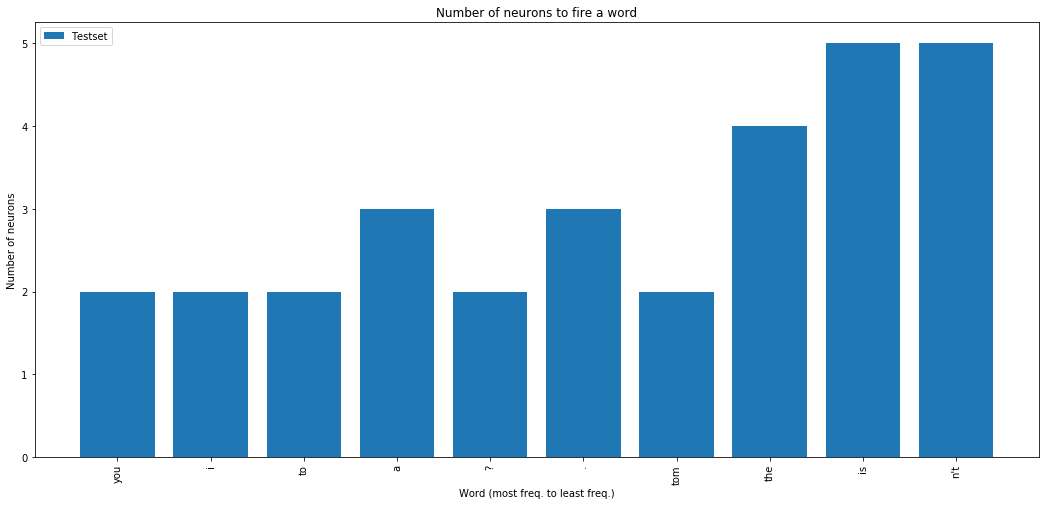

In [95]:
plt.subplots(figsize=(18, 8))
plt.title('Number of neurons to fire a word')
_key = [k for k, v in wordset.most_common() if k in ig_important_neurons_dict]
bar = plt.bar(_key, [len(ig_important_neurons_dict[k]) for k in _key], label='Testset', color='C0')
plt.xticks(_key, _key, rotation='vertical')
plt.xlabel('Word (most freq. to least freq.)')
plt.ylabel('Number of neurons')
plt.legend()
plt.show()

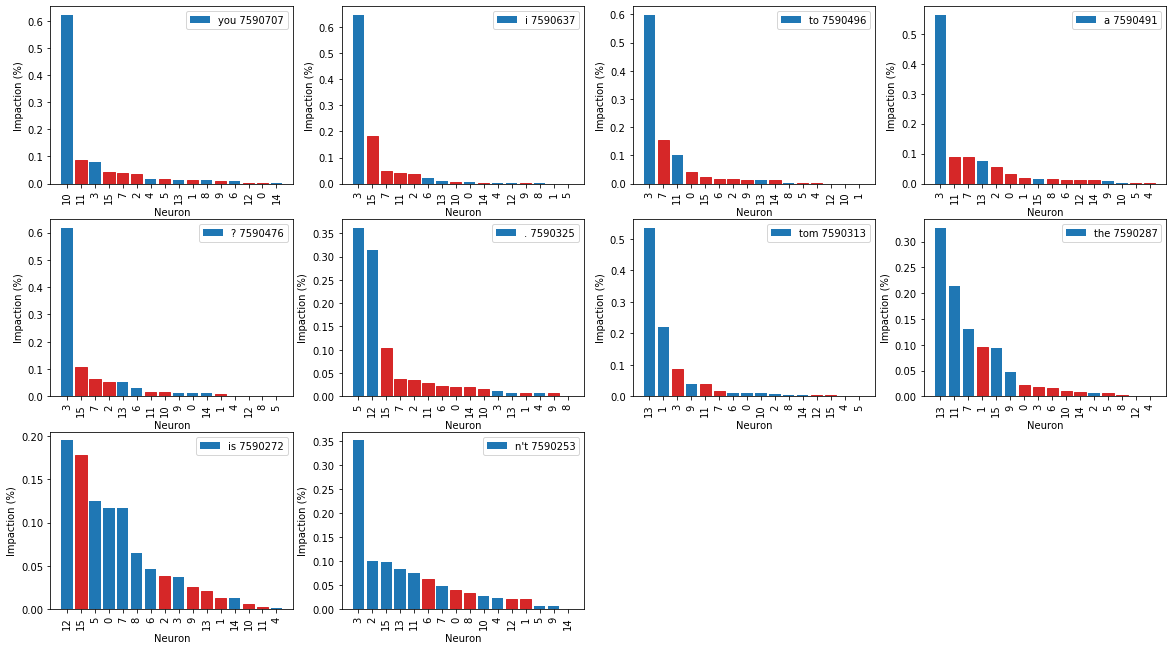

In [96]:
# xword = 'you'

figure = plt.figure(figsize=(20, 15))
for __idx, xword in enumerate(ig_dict.keys()):
    plt.subplot(4,4,__idx+1)
    sst = sorted([(idx, i) for idx, i in enumerate(ig_dict[xword])], reverse=True, key=lambda x: (abs(x[1]), x[0]))
    sum_sst = sum([abs(i) for _, i in sst])
    bar = plt.bar([str(idx) for idx, _ in sst], [abs(i)/sum_sst for _, i in sst], label='{} {}'.format(xword, word_counter[xword]), color='C0')
    for idx, (_, i) in enumerate(list(sst)):
        if i < 0.0:
            bar[idx].set_color('C3')
    plt.xticks([str(idx) for idx, _ in sst], [str(idx) for idx, _ in sst], rotation='vertical')
    plt.xlabel('Neuron')
    plt.ylabel('Impaction (%)')
    plt.legend()

In [164]:
with open('../data/nonsence_english_corpus_train.txt', 'r') as fin:
    tmp = fin.readlines()

In [165]:
from collections import Counter

counter = Counter([word for sent in tmp for word in sent.strip().split()])

In [166]:
counter.most_common()

[('you', 7590707),
 ('i', 7590637),
 ('to', 7590496),
 ('a', 7590491),
 ('?', 7590476),
 ('.', 7590325),
 ('tom', 7590313),
 ('the', 7590287),
 ('is', 7590272),
 ("n't", 7590253)]

In [103]:
pos_dict = {}

for sent in tmp:
    words = sent.strip().split()
    for idx, word in enumerate(words):
        if word not in pos_dict:
            pos_dict[word] = {i:0 for i in range(1, 11)}
        pos_dict[word][idx+1] += 1

In [210]:
np.arange(1, 50, step=5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])

In [208]:
842704/_max[1]

0.9985307081986482

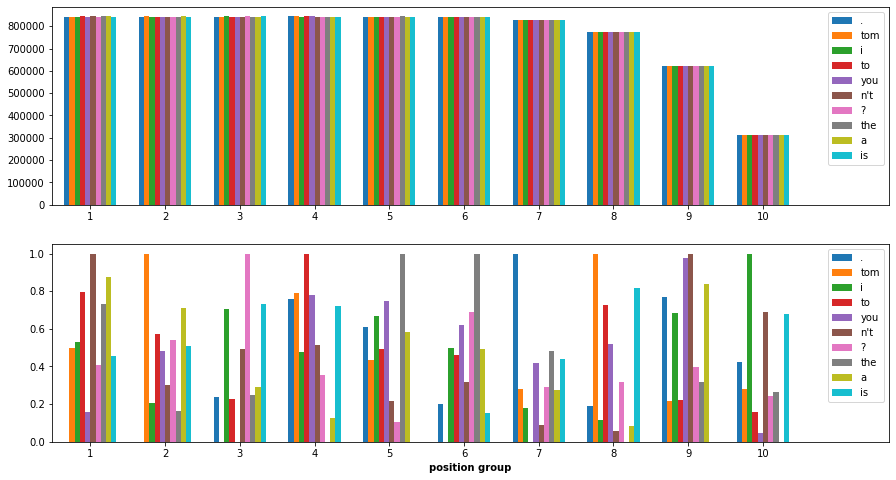

In [237]:
fig = plt.figure(figsize=(15, 8))

barWidth = 0.35

# Set position of bar on X axis
_r = [np.arange(1, 50, step=5)]
for i in range(9):
    _r.append(_r[-1]+barWidth)

_max = {}
for k, v in pos_dict.items():
    for _k, _v in v.items():
        if _k not in _max:
            _max[_k] = []
        _max[_k].append(_v)

_min = {}
for k, v in _max.items():
    _max[k] = max(v)
    _min[k] = min(v)

plt.subplot(2,1,1)
for idx, (k, v) in enumerate(pos_dict.items()):
    plt.bar(_r[idx], [_v for _k, _v in v.items()], color = 'C{}'.format(idx), width=barWidth, label=k)
plt.xticks([r + (barWidth/2) for r in _r[4]], range(1, 11))

plt.xlim((0, 56))
plt.legend()
    
plt.subplot(2,1,2)
for idx, (k, v) in enumerate(pos_dict.items()):
    plt.bar(_r[idx], [(_v-_min[_k])/(_max[_k]-_min[_k]) for _k, _v in v.items()], color = 'C{}'.format(idx), width=barWidth, label=k)
plt.xticks([r + (barWidth/2) for r in _r[4]], range(1, 11))
plt.xlim((0, 56))

plt.xlabel('position group', fontweight='bold')
plt.legend()

In [ ]:
xword = 'look'
plt.subplots(figsize=(18, 8))
plt.title('Integrated Gradient')
sst = sorted([(idx, i) for idx, i in enumerate(ig_dict[xword])], reverse=True, key=lambda x: (abs(x[1]), x[0]))
sum_sst = sum([abs(i) for _, i in sst])
bar = plt.bar([str(idx) for idx, _ in sst], [abs(i)/sum_sst for _, i in sst], label='{} {}'.format(xword, word_counter[xword]), color='C0')
for idx, (_, i) in enumerate(list(sst)):
    if i < 0.0:
        bar[idx].set_color('C3')
plt.xticks([str(idx) for idx, _ in sst], [str(idx) for idx, _ in sst], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Impaction (%)')
plt.legend()
plt.show()

In [ ]:
xword = 'Tom'
plt.subplots(figsize=(15, 8))
plt.title('Integrated Gradient')
bar = plt.bar([idx for idx, _ in enumerate(ig_dict[xword])], [i for i in ig_dict[xword]], label='{} {}'.format(xword, word_counter[xword]), color='C1')
plt.xticks([idx for idx, _ in enumerate(ig_dict[xword])], [idx for idx, _ in enumerate(ig_dict[xword])], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Gradient')
plt.legend()
plt.show()

In [ ]:
xword = 'solve'
plt.subplots(figsize=(15, 8))
plt.title('Integrated Gradient')
bar = plt.bar([idx for idx, _ in enumerate(ig_dict[xword])], [i for i in ig_dict[xword]], label='{} {}'.format(xword, word_counter[xword]), color='C1')
plt.xticks([idx for idx, _ in enumerate(ig_dict[xword])], [idx for idx, _ in enumerate(ig_dict[xword])], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Gradient')
plt.legend()
plt.show()

## Verify important neuron

In [ ]:
mykey = ['apple', 'Tom', '.', '?', 'I', 'to', 'you', 'the', 'a', 'is', 'are', 'has', 'have', 'Do', 'They', 'stay', 'mean', 'solve', 'space', 'ruined', 'Hiroshima', 'stupidest', 'flea', 'behalf', 'nick', 'cutbacks', 'cobra', 'Alaska']

In [ ]:
_dataloader = dataloaders[-1]
word_metric = WordAccuracy(_dataloader)
ig_neuron_impact_dict = {}

In [ ]:
trange = tqdm(mykey, total=len(mykey))

for xword in trange:
    # Loading new encoder and decoder
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()
    # End Loading

    # Removing i-th neuron
    try:
        decoder.out.weight[:, ig_important_neurons_dict[xword]] = decoder.out.weight[:, ig_important_neurons_dict[xword]] * 0.0
    except:
        continue
    # End Removing

    metric.reset()
    word_metric.reset(_dataloader, verbose=False)
    loss = 0

    for i, batch in enumerate(_dataloader):

        _a, _l, _s = predictWithDiffModel(batch, encoder, decoder)
        _s = np.stack(_s)

        loss += _l.item()
        metric.update(_a, batch)
        word_metric.update(_s, batch)
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score(), w_acc=word_metric.print_score())

    ig_neuron_impact_dict[xword] = (sorted([(k, v.n, v.get_score(), v.get_predict_rate()) for k, v in word_metric.get_score_dict().items() if v.get_score() < 1.0], 
                                    key=lambda x: (x[1], x[2], x[0])), 
                                    float(word_metric.print_score()))
    
    _v = [v for v in ig_neuron_impact_dict[xword][0] if v[0] == xword]
    print(_v)

In [ ]:
[_w for k, v in ig_neuron_impact_dict.items() for _w in v[0] if _w[0] == k]

In [ ]:
_ = []
for k, v in ig_important_neurons_dict.items():
    _ += v
cnt = cnt = collections.Counter(_)

plt.subplots(figsize=(18, 8))
plt.title('Neuron Histogram')
plt.bar([str(i[0]) for i in cnt.most_common()], [i[1]/len(ig_important_neurons_dict) for i in cnt.most_common()], label='Neuron', color='C0')
plt.xticks([str(i[0]) for i in cnt.most_common()], [str(i[0]) for i in cnt.most_common()], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Freq. (%)')
plt.legend()
plt.show()

In [ ]:
len(ig_important_neurons_dict)

In [ ]:
_cnt = [i[0] for i in cnt.most_common()[:6]]
counter = 0
print(_cnt)
for k, v in ig_important_neurons_dict.items():
    if any(_n in _cnt for _n in v):
#         print(k, wordset.most_common()[word_dict[k]-4])
        counter += 1
    else:
        print(k, wordset.most_common()[word_dict[k]-4])
print(counter)

# Observe variety of nuerons of a word 

In [13]:
def predictWithAutoencoderHidden(batch):
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        encoder_hn = [None]
        
        encoder_hn_dict = []
        
        for x in batch['sentence'][1:]:
            _, hn = encoder(x, encoder_hn[-1])
            if len(encoder_hn_dict) == 0:
                encoder_hn_dict.append(np.zeros(hn.shape[-1]).astype(np.float32))
            encoder_hn_dict.append(hn.clone().cpu().detach().numpy().reshape(-1))
            encoder_hn.append(hn)
        
        encoder_hn.pop(0)
        encoder_hn = torch.stack(encoder_hn, dim=0).squeeze(1).transpose(0, 1) # batch, seq_len, dim
        
        idx = batch['sentence_len'].unsqueeze(1).repeat(1, hidden_size).view(batch_size, 1, hidden_size)
        decoder_hidden = torch.gather(encoder_hn, 1, idx).transpose(0, 1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        
        _loss = 0
        _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
        
        decoder_hn_dict = [decoder_hidden.clone().cpu().detach().numpy().reshape(-1)]

        for di in range(seq_len):
            if use_same_embedding:
                decoder_input = encoder.get_embedding(decoder_input).detach()

            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            decoder_hn_dict.append(decoder_hidden.clone().cpu().detach().numpy().reshape(-1))
            decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

            _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])

            _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                 (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
        
        return _acc, _loss/seq_len, decoded_sentence, np.array(encoder_hn_dict), np.array(decoder_hn_dict)

In [ ]:
spec_words_hiddens = {}
mykey = ['Tom', 'solve', 'space', 'ruined', '?', '.']

for xword in mykey:
    with open('../data/english_short_corpus_small_4to12_correct_train.txt', 'r') as fin:
        tmp = fin.readlines()

    sent_list = []
    for sent in tmp:
        sent = sent.strip().split()
        if xword in sent:
            sent_list.append(' '.join(sent))

    spec_word_hiddens = {}

    for _sent in tqdm(sent_list, total=len(sent_list), desc=xword):
        t1 = text2batch(_sent)
        _, _, ds, enhidden, dehidden = predictWithAutoencoderHidden(t1)
        ds = predict2sentence(t1['sentence'], ds)

        idx = ds[0][1].split().index(xword)

        prev_enhidden = enhidden[idx-1]
        curr_enhidden = enhidden[idx]

        prev_dehidden = dehidden[idx-1]
        curr_dehidden = dehidden[idx]
        next_dehidden = dehidden[idx+1]

        if idx not in spec_word_hiddens:
            spec_word_hiddens[idx] = {'encoder':[[], []], 'decoder':[[], [], []]}

        spec_word_hiddens[idx]['encoder'][0].append(prev_enhidden)
        spec_word_hiddens[idx]['encoder'][1].append(curr_enhidden)

        spec_word_hiddens[idx]['decoder'][0].append(prev_dehidden)
        spec_word_hiddens[idx]['decoder'][1].append(curr_dehidden)
        spec_word_hiddens[idx]['decoder'][2].append(next_dehidden)
    
    spec_words_hiddens[xword] = spec_word_hiddens

In [ ]:
def IntegratedGradientWithGivenHiddens(hiddens, word, steps=10, _r=None):
    
    def update(_x, _w, _b, _y_hat):
        _a = _x@_w.transpose(1, 0) + _b
        _a = nn.Softmax(dim=1)(_a)
        _a = _a.gather(1, _y_hat).sum()
        
        _a.backward()
        
        with torch.no_grad():
            try:
                _h = _x.grad.clone().numpy()
            except:
                _h = _x.grad.clone().cpu().numpy()
                
        return _h
    
    device = 'cuda'
    _h = [0.0 for i in range(hiddens.shape[1])]

    _y_hat = [torch.tensor([word_dict[word]]).requires_grad_(False).long().to(device) for i in range(steps + 1)]
    _y_hat = torch.stack(_y_hat, dim=0)
    _w = decoder.out.weight.clone().detach().cpu().to(device)
    _b = decoder.out.bias.clone().detach().cpu().to(device)
    
    _ig = np.array(_h)
    
    trange = tqdm(hiddens,
                  total=len(hiddens),
                  desc='Evaluating {}, size of {}'.format(word_dict[word], hiddens.shape[0]))
    
    for hidden in trange:
        _base = torch.zeros(hidden.shape)
        _hiddens = [_base + float(i/steps)*hidden.cpu() for i in range(steps + 1)]
        _hiddens = nn.Parameter(torch.stack(_hiddens, dim=0).to(device))
        
        _g = update(_hiddens, _w, _b, _y_hat)
        
        _ig += ((hidden.cpu().numpy() - _base.cpu().numpy()) * np.mean(_g, axis=0))
        
        trange.set_postfix(ranking=_r)
        
    return _ig/hiddens.shape[0]

In [ ]:
spec_words_ig_dict = {}

for k, spec_word_hiddens in spec_words_hiddens.items():
    spec_ig_dict = {}
    for _k in spec_word_hiddens.keys():
        spec_ig_dict[_k] = IntegratedGradientWithGivenHiddens(torch.from_numpy(np.array(spec_word_hiddens[_k]['decoder'][1])), k, _r=_k)
    spec_words_ig_dict[k] = spec_ig_dict

In [32]:
sorted(spec_words_ig_dict['Tom'].keys())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
# _ig = np.stack(list(spec_words_ig_dict['this'].values())).mean(axis=0)

# plt.subplots(figsize=(18, 8))
# plt.title('Integrated Gradient')

# sst = sorted([(idx, i) for idx, i in enumerate(_ig)], reverse=True, key=lambda x: (abs(x[1]), x[0]))
# sum_sst = sum([abs(i) for _, i in sst])
# bar = plt.bar([str(idx) for idx, _ in sst], [abs(i)/sum_sst for _, i in sst], label='{} {}'.format(xword, 'MEAN'))

# plt.xticks([str(idx) for idx, _ in sst], [str(idx) for idx, _ in sst], rotation='vertical')
# plt.xlabel('Neuron')
# plt.ylabel('Impaction (%)')
# plt.legend()
# plt.show()

In [35]:
ig_neuron_words_impact_dict = collections.OrderedDict()

for xword, _ig in spec_words_ig_dict.items():
    _ig = np.stack(list(_ig.values())).mean(axis=0)
    sst = sorted([(idx, i) for idx, i in enumerate(_ig)], reverse=True, key=lambda x: (x[1], x[0]))

    # Set sst nueron to zero
    _dataloader = dataloaders[-2]
    word_metric = WordAccuracy(_dataloader)
    ig_neuron_impact_dict = {}

    trange = tqdm(sst, total=len(sst), desc=xword)
    important_neuron = []

    for xneuron in trange:
        # Loading new encoder and decoder
        saved_model = torch.load(saved_model_path)
        decoder.load_state_dict(saved_model['decoder'])

        decoder = decoder.to(device)

        encoder.eval()
        decoder.eval()
        # End Loading

        important_neuron.append(xneuron[0])

        # Removing i-th neuron
        try:
            decoder.out.weight[:, important_neuron] = decoder.out.weight[:, important_neuron] * 0.0
        except:
            continue
        # End Removing

        metric.reset()
        word_metric.reset(_dataloader, verbose=False)
        loss = 0

        for i, batch in enumerate(_dataloader):

            _a, _l, _s = predictWithDiffModel(batch, encoder, decoder)
            _s = np.stack(_s)

            loss += _l.item()
            metric.update(_a, batch)
            word_metric.update(_s, batch)
            trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score(), w_acc=word_metric.print_score())

        ig_neuron_impact_dict[important_neuron[-1]] = (sorted([(k, v.n, v.get_score(), v.get_predict_rate()) for k, v in word_metric.get_score_dict().items() if v.get_score() < 1.0], 
                                        key=lambda x: (x[1], x[2], x[0])), 
                                        float(word_metric.print_score()))

        _v = [v for v in ig_neuron_impact_dict[important_neuron[-1]][0] if v[0] == xword]
        print(_v)
        
        if _v[0][2] == 0.0:
            break
            
    ig_neuron_words_impact_dict[xword] = ig_neuron_impact_dict

[('Tom', 126215, 0.9998573862060769, 1.0001505367824743)]
[('Tom', 126215, 0.9997385413778077, 1.0007447609238205)]
[('Tom', 126215, 0.999096779305154, 0.9995880045953334)]
[('Tom', 126215, 0.9970764172245771, 0.9997226954007051)]
[('Tom', 126215, 0.9954601275601157, 0.9978132551598463)]
[('Tom', 126215, 0.9855484688824625, 0.9859208493443727)]
[('Tom', 126215, 0.9314106881115557, 0.9314819950085172)]
[('Tom', 126215, 0.8605791704630987, 0.8605791704630987)]
[('Tom', 126215, 0.7942082953690132, 0.7942082953690132)]
[('Tom', 126215, 0.6657845739412906, 0.6658004199183932)]
[('Tom', 126215, 0.46079309115398326, 0.46079309115398326)]
[('Tom', 126215, 0.05651467733629125, 0.05651467733629125)]
[('Tom', 126215, 0.002931505763974171, 0.002931505763974171)]
[('Tom', 126215, 0.0, 0.0)]


[]


IndexError: list index out of range

In [ ]:
with open('../data/ig_neuron_words_impact_dict_2.pkl', 'wb') as fout:
    pickle.dump(ig_neuron_words_impact_dict, fout)

In [ ]:
plt.subplots(figsize=(18, 8))
plt.title('Integrated Gradient')

for _k, _ig in spec_ig_dict.items():
    sst = sorted([(idx, i) for idx, i in enumerate(_ig)], reverse=True, key=lambda x: (abs(x[1]), x[0]))
    sum_sst = sum([abs(i) for _, i in sst])
    bar = plt.bar([str(idx) for idx, _ in sst], [abs(i)/sum_sst for _, i in sst], label='{} {}'.format(xword, _k))

plt.xticks([str(idx) for idx, _ in sst], [str(idx) for idx, _ in sst], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Impaction (%)')
plt.legend()
plt.show()

In [ ]:
spec_var_dict = {}
_tmp_list = []
for k, v in spec_ig_dict.items():
    _tmp_list.append(v)
_tmp_list = np.array(_tmp_list)

In [ ]:
plt.subplots(figsize=(18, 8))
plt.title('IG Neurons Variance')

sst = sorted([(idx, i) for idx, i in enumerate(_tmp_list.var(axis=0))], reverse=True, key=lambda x: (abs(x[1]), x[0]))

bar = plt.bar([str(idx) for idx, i in sst], [i for idx, i in sst], label='{}'.format(xword))

plt.xticks([str(idx) for idx, i in sst], [str(idx) for idx, i in sst], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Variance')
plt.legend()
plt.show()

In [ ]:
plt.subplots(figsize=(18, 8))
plt.title('Integrated Gradient')

sst = sorted([(idx, i) for idx, i in enumerate(spec_ig_dict[10])], reverse=True, key=lambda x: (abs(x[1]), x[0]))
sum_sst = sum([abs(i) for _, i in sst])
bar = plt.bar([str(idx) for idx, _ in sst], [abs(i)/sum_sst for _, i in sst], label='{} {}'.format(xword, 11))

plt.xticks([str(idx) for idx, _ in sst], [str(idx) for idx, _ in sst], rotation='vertical')
plt.xlabel('Neuron')
plt.ylabel('Impaction (%)')
plt.legend()
plt.show()

## Find relation between Tom's neurons

In [ ]:
xword = 'Tom'

# Loading new encoder and decoder
saved_model = torch.load(saved_model_path)
decoder.load_state_dict(saved_model['decoder'])

decoder = decoder.to(device)

encoder.eval()
decoder.eval()
# End Loading

# Removing i-th neuron
decoder.out.weight[:, ig_important_neurons_dict[xword][:-2]] = decoder.out.weight[:, ig_important_neurons_dict[xword][:-2]] * 0.0
# End Removing

metric.reset()
word_metric.reset(_dataloader, verbose=False)
loss = 0

for i, batch in enumerate(_dataloader):

    _a, _l, _s = predictWithDiffModel(batch, encoder, decoder)
    _s = np.stack(_s)

    loss += _l.item()
    metric.update(_a, batch)
    word_metric.update(_s, batch)
    trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score(), w_acc=word_metric.print_score())

# Change wt-1 to random word if wt is 'that'

In [31]:
import numpy as np

In [84]:
def predictWithDiffWord(batch, encoder, decoder, use_teacher_forcing=False, target_word='that', replace_word='you'):
    
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        encoder_hn = [None]
        
        for x in batch['sentence'][1:]:
            _, hn = encoder(x, encoder_hn[-1])
            encoder_hn.append(hn)
        
        encoder_hn.pop(0)
        encoder_hn = torch.stack(encoder_hn, dim=0).squeeze(1).transpose(0, 1) # batch, seq_len, dim
        
        idx = batch['sentence_len'].unsqueeze(1).repeat(1, hidden_size).view(batch_size, 1, hidden_size)
        decoder_hidden = torch.gather(encoder_hn, 1, idx).transpose(0, 1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        decoded_fake_sentence = []
        
        if use_teacher_forcing:
            _loss = 0
            _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
            
            for di in range(seq_len):
                if use_same_embedding:
                    decoder_input = encoder.get_embedding(decoder_input).detach()
                    
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
                decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

                _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])
                
                _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                     (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
                
#                 decoder_input = batch['sentence'][di+1].unsqueeze(1)
        
        else:
            
            _loss = 0
            _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
            
            for di in range(seq_len):
                target_idx = (batch['sentence'][di+1] == word_dict[target_word]).nonzero().reshape(-1)
                decoder_input[target_idx] = np.random.randint(0, len(word_dict))
                decoded_fake_sentence.append(decoder_input.squeeze().cpu().detach().numpy())
                
                if use_same_embedding:
                    decoder_input = encoder.get_embedding(decoder_input).detach()
                    
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
                decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

                _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])
                
                _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                     (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
                
            decoded_fake_sentence.append(decoder_input.squeeze().cpu().detach().numpy())
        
        return _acc, _loss/seq_len, decoded_sentence, decoded_fake_sentence

In [124]:
avg_acc = avg_acc[:200]
avg_word_acc = avg_word_acc[:200]
avg_specific_word_acc = avg_specific_word_acc[:200]
avg_specific_predict_rate = avg_specific_predict_rate[:200]

In [ ]:
trange = tqdm(enumerate(wordset.most_common()[3000:]), total=len(wordset.most_common()[3000:]))

for _idx, xword in trange:
    xword = xword[0]
    
    saved_model = torch.load(saved_model_path)
    decoder.load_state_dict(saved_model['decoder'])

    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    metric.reset()
    word_metric.reset(dataloaders[-1], verbose=False)
    loss = 0
    
    if xword not in word_metric.word_dict:
        continue

    for i, batch in enumerate(dataloaders[-1]):

        _a, _l, _s, _f = predictWithDiffWord(batch, encoder, decoder, use_teacher_forcing=False, 
                                             target_word=xword, replace_word='this')
        
        _s = np.stack(_s)
        _f = np.stack(_f)

        loss += _l.item()
        metric.update(_a, batch)
        word_metric.update(_s, batch)
        trange.set_postfix(loss=loss / (i + 1), accuracy=metric.print_score(), w_acc=word_metric.print_score())
    
    avg_acc.append(float(metric.print_score()))
    avg_word_acc.append(float(word_metric.print_score()))
    avg_specific_word_acc.append(float(word_metric.word_dict[xword].get_score()))
    avg_specific_predict_rate.append(float(word_metric.word_dict[xword].get_predict_rate()))
    
    print(metric.print_score(), word_metric.print_score(), word_metric.word_dict[xword].get_score(), word_metric.word_dict[xword].get_predict_rate())

1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0
1.00000 1.00000 1.0 1.0


In [92]:
predict2sentence(batch['sentence'], _f)

[('<SOS> Tom poured some milk in a bowl for his cats . <EOS>',
  '<SOS> Tom poured some milk in a bowl for his cats . <EOS>'),
 ('<SOS> A prize was given in honor of the great scientist . <EOS>',
  '<SOS> A prize was given in honor of the great scientist . <EOS>'),
 ("<SOS> I do n't know why Tom is looking for Mary . <EOS>",
  "<SOS> I do n't know why Tom is looking for Mary . <EOS>"),
 ('<SOS> Tom heard Mary cry and wondered what the matter was . <EOS>',
  '<SOS> Tom heard Mary cry and wondered what the matter was . <EOS>'),
 ("<SOS> It 's said that nothing is more precious than time . <EOS>",
  "<SOS> It 's thirty-six that nothing is more precious than time . <EOS>"),
 ("<SOS> Who told you I was n't able to do that ? <EOS>",
  "<SOS> Who told you I was n't able to some that ? <EOS>"),
 ("<SOS> Tom did n't tell Mary what needed to be done . <EOS>",
  "<SOS> Tom did n't tell Mary what needed to be done . <EOS>"),
 ('<SOS> I only found out about that a few days ago . <EOS>',
  '<SOS> I 

# Testing Integrated Gradient with animation

In [ ]:
_xword = '?'
print(word_dict[_xword])
print(idx2word[word_dict[_xword]])

In [97]:
word_metric.word_dict['that'].n_predict

1918

In [94]:
word_metric.word_dict['that'].get_predict_rate(), word_metric.word_dict['that'].get_score()

(0.9994788952579469, 0.9994788952579469)

In [ ]:
device = 'cpu'
_lr = 5e-3
_h = [0.0 for i in range(128)]

_x = nn.Parameter(torch.zeros(128)).to(device)
_y_hat = torch.tensor([word_dict[_xword]]).requires_grad_(False).long().to(device)
_w = decoder.out.weight.clone().detach().cpu()
_b = decoder.out.bias.clone().detach().cpu()

In [ ]:
def update():
    _a = _x@_w.transpose(1, 0) + _b
    _a = nn.LogSoftmax(dim=0)(_a)
    _loss = F.nll_loss(_a.unsqueeze(0), _y_hat)
    with torch.no_grad():
        print(_loss.item(), torch.argmax(_a).item())
    _loss.backward()
    with torch.no_grad():
        _x.sub_(_lr * _x.grad)
        _h = _x.grad.clone().numpy()
        _x.grad.zero_()
    return _h

In [25]:
predict2sentence(batch['sentence'], _f)

[('<SOS> Tom poured some milk in a bowl for his cats . <EOS>',
  '<EOS> Tom poured some milk in a bowl for his cats . <EOS>'),
 ('<SOS> A prize was given in honor of the great scientist . <EOS>',
  '<SOS> A prize was given in honor of the great scientist . <EOS>'),
 ("<SOS> I do n't know why Tom is looking for Mary . <EOS>",
  "<SOS> I do n't know <EOS> Tom is looking for Mary . <EOS>"),
 ('<SOS> Tom heard Mary cry and wondered what the matter was . <EOS>',
  '<EOS> Tom heard everybody cry and guys for the matter was . <EOS>'),
 ("<SOS> It 's said that nothing is more precious than time . <EOS>",
  "<SOS> It 's said that nothing is more precious than time . <EOS>"),
 ("<SOS> Who told you I was n't able to do that ? <EOS>",
  "<SOS> Who told you I was n't able to do that ? <EOS>"),
 ("<SOS> Tom did n't tell Mary what needed to be done . <EOS>",
  "<EOS> Tom did n't tell Mary what needed to be done . <EOS>"),
 ('<SOS> I only found out about that a few days ago . <EOS>',
  '<SOS> I only f

In [81]:
batch['sentence'].shape

torch.Size([13, 39])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Change of Gradient')
bar = plt.bar([idx for idx, _ in enumerate(_h)], [i for i in _h], label=_xword, color='C1')
plt.xticks([idx for idx, _ in enumerate(_h)], [idx for idx, _ in enumerate(_h)], rotation='vertical')
plt.ylim(-2.5, 2.0)
plt.xlabel('Neuron')
plt.ylabel('Gradient')
plt.legend()
plt.close()

def animate(i):
    _h = update()
    for b, h in zip(bar, _h):
        b.set_height(h)
    return bar

frames = 500    
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=5, repeat=True)
HTML(anim.to_html5_video())

# Feed random text and observe the differences

In [38]:
def text2batch(text):
    '''
    Args:
        text: a list of text
    Return:
        batch: dict with key of sentence and sentence_len
               sentence - torch of size (batch/1, length)
               sentence_len - list of length (batch/1)
    '''
    batch = {}
    batch['sentence'] = torch.tensor([word_dict[t] for t in ['<SOS>'] + text.split() + ['<EOS>']]).unsqueeze(0)
    batch['sentence_len'] = [len(text.split())]
    return batch

In [39]:
def predictWithAutoencoderHidden(batch):
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        encoder_hn = [None]
        
        encoder_hn_dict = []
        
        for x in batch['sentence'][1:]:
            _, hn = encoder(x, encoder_hn[-1])
#             _, hn, _, _, _ = encoder2(x, encoder_hn[-1])
            if len(encoder_hn_dict) == 0:
                encoder_hn_dict.append(np.zeros(hn.shape[-1]).astype(np.float32))
            encoder_hn_dict.append(hn.clone().cpu().detach().numpy().reshape(-1))
            encoder_hn.append(hn)
        
        encoder_hn.pop(0)
        encoder_hn = torch.stack(encoder_hn, dim=0).squeeze(1).transpose(0, 1) # batch, seq_len, dim
        
        idx = batch['sentence_len'].unsqueeze(1).repeat(1, hidden_size).view(batch_size, 1, hidden_size)
        decoder_hidden = torch.gather(encoder_hn, 1, idx).transpose(0, 1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        
        _loss = 0
        _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
        
        decoder_hn_dict = [decoder_hidden.clone().cpu().detach().numpy().reshape(-1)]

        for di in range(seq_len):
            if use_same_embedding:
                decoder_input = encoder.get_embedding(decoder_input).detach()

            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
#             decoder_output, decoder_hidden, _, _, _ = decoder2(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            decoder_hn_dict.append(decoder_hidden.clone().cpu().detach().numpy().reshape(-1))
            decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

            _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])

            _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                 (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
        
        return _acc, _loss/seq_len, decoded_sentence, np.array(encoder_hn_dict), np.array(decoder_hn_dict)

In [40]:
def predictWithGivenHidden(batch, hidden):
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        
        decoder_hidden = torch.from_numpy(hidden).to(device).view(1, 1, -1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        
        _loss = 0
        _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
        
        decoder_hn_dict = [decoder_hidden.clone().cpu().detach().numpy().reshape(-1)]

        for di in range(seq_len):
            if use_same_embedding:
                decoder_input = encoder.get_embedding(decoder_input).detach()

            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            decoder_hn_dict.append(decoder_hidden.clone().cpu().detach().numpy().reshape(-1))
            decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

            _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])

            _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                 (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
        
        return _acc, _loss/seq_len, decoded_sentence, np.array(decoder_hn_dict)

In [231]:
_tmp_hn = t1_en_hn[-2] + (t4_en_hn[-1]-t3_en_hn[-1]) + (t6_en_hn[-1]-t4_en_hn[-1]) + (t2_en_hn[-1]-t2_en_hn[-2])

In [229]:
_tmp_hn = t1_en_hn[-1] + (t4_en_hn[-1]-t3_en_hn[-1]) + (t6_en_hn[-1]-t4_en_hn[-1])

In [232]:
_t = text2batch('I can a a a a a a a a a a a a a a a a a a a a a a a a . ')
_, _, tmp_sent, tmp_de_hn = predictWithGivenHidden(_t, _tmp_hn)
__ = predict2sentence(_t['sentence'], tmp_sent)
print(__[0][1])

<SOS> We can have another that went to another woman . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>


In [43]:
l = ['I thought Tom and Mary would be married by now .', 
     'I wonder if Tom knows the combination to this safe .', 
     'Who \'s the person Tom went to visit in Boston ?', 
     'It was Tom who warned Mary not to do that .', 
     'Tell Tom what you think about the article Mary wrote .']

In [209]:
t1 = text2batch('We can leave .')
t2 = text2batch('You can leave .')
t3 = text2batch('Tom can leave .')
t4 = text2batch('Tom can leave another , went to .')
t5 = text2batch('You can n\'t leave .')
t6 = text2batch('Tom can leave another , went to another woman .')

_, _, t1_decoded_sentence, t1_en_hn, t1_de_hn = predictWithAutoencoderHidden(t1)
_, _, t2_decoded_sentence, t2_en_hn, t2_de_hn = predictWithAutoencoderHidden(t2)
_, _, t3_decoded_sentence, t3_en_hn, t3_de_hn = predictWithAutoencoderHidden(t3)
_, _, t4_decoded_sentence, t4_en_hn, t4_de_hn = predictWithAutoencoderHidden(t4)
_, _, t5_decoded_sentence, t5_en_hn, t5_de_hn = predictWithAutoencoderHidden(t5)
_, _, t6_decoded_sentence, t6_en_hn, t6_de_hn = predictWithAutoencoderHidden(t6)

_t1_sentence = predict2sentence(t1['sentence'], t1_decoded_sentence)
_t2_sentence = predict2sentence(t2['sentence'], t2_decoded_sentence)
_t3_sentence = predict2sentence(t3['sentence'], t3_decoded_sentence)
_t4_sentence = predict2sentence(t4['sentence'], t4_decoded_sentence)
_t5_sentence = predict2sentence(t5['sentence'], t5_decoded_sentence)
_t6_sentence = predict2sentence(t6['sentence'], t6_decoded_sentence)

In [210]:
_t4_sentence, _t6_sentence, _t2_sentence

([('<SOS> Tom can leave another , went to . <EOS>',
   '<SOS> Tom can leave another , went to . <EOS>')],
 [('<SOS> Tom can leave another , went to another woman . <EOS>',
   '<SOS> Tom can leave another , went to another woman . <EOS>')],
 [('<SOS> You can leave . <EOS>', '<SOS> You can leave . <EOS>')])

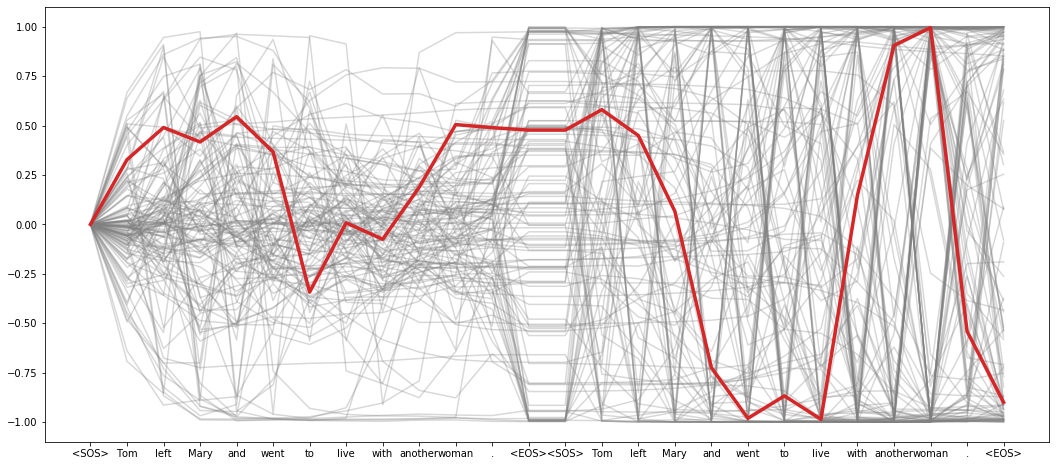

In [46]:
x = _t6_sentence[0][1].split() + _t6_sentence[0][1].split()
y = np.concatenate((t6_en_hn, t6_de_hn), axis=0)
_ = plt.figure(figsize=(18, 8))
_ = plt.plot(range(len(x)), y, color='gray', alpha=0.3)
_ = plt.xticks(range(len(x)), x)

_ = plt.plot(range(len(x)), y[:, 8], color='C3', linewidth=3.5)

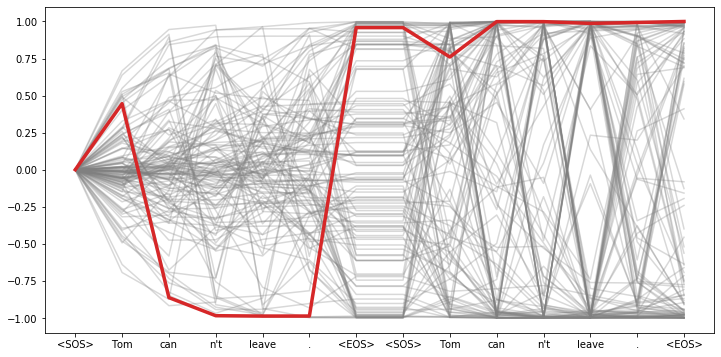

In [47]:
x = _t4_sentence[0][1].split() + _t4_sentence[0][1].split()
y = np.concatenate((t4_en_hn, t4_de_hn), axis=0)
_ = plt.figure(figsize=(12, 6))
_ = plt.plot(range(len(x)), y, color='gray', alpha=0.3)
_ = plt.xticks(range(len(x)), x)

_ = plt.plot(range(len(x)), y[:, 2], color='C3', linewidth=3.5)

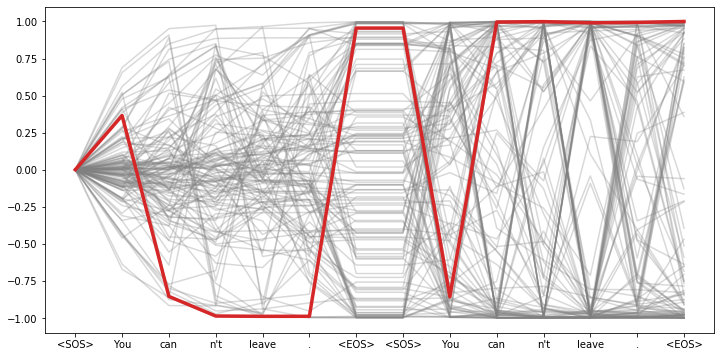

In [48]:
x = _t5_sentence[0][1].split() + _t5_sentence[0][1].split()
y = np.concatenate((t5_en_hn, t5_de_hn), axis=0)
_ = plt.figure(figsize=(12, 6))
_ = plt.plot(range(len(x)), y, color='gray', alpha=0.3)
_ = plt.xticks(range(len(x)), x)

_ = plt.plot(range(len(x)), y[:, 2], color='C3', linewidth=3.5)

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(t1_en_hn.transpose(), cmap='bwr', xticklabels=_t1_sentence[0][1].split(), ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8)) 
sns.heatmap(t2_en_hn.transpose(), cmap='bwr', xticklabels=_t2_sentence[0][1].split(), ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(t3_en_hn.transpose(), cmap='bwr', xticklabels=_t3_sentence[0][1].split(), ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(t1_de_hn.transpose(), cmap='bwr', xticklabels=_t1_sentence[0][1].split(), ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8)) 
sns.heatmap(t2_de_hn.transpose(), cmap='bwr', xticklabels=_t2_sentence[0][1].split(), ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 8)) 
sns.heatmap(np.array([t1_en_hn[-1], t2_en_hn[-1]]).transpose(), cmap='bwr', ax=ax, xticklabels=['{n\'t leave} - {leave}'])

In [ ]:
not_leave_minus_leave = (t2_en_hn[4] - t1_en_hn[3])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8)) 
sns.heatmap(np.array([t1_en_hn[2] + not_leave_minus_leave, t2_en_hn[3]]).transpose(), cmap='bwr', xticklabels=[], ax=ax)

In [ ]:
# {You} - {We}
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(np.array([(t1_en_hn[1] - t3_en_hn[1]), (t1_en_hn[1] - t4_en_hn[1]), (t3_en_hn[1] - t4_en_hn[1]), t1_en_hn[1], t3_en_hn[1], t4_en_hn[1]]).transpose(), cmap='bwr', xticklabels=['{We} - {You}', '{We} - {I}', '{You} - {I}', 'We', 'You', 'I'], ax=ax)


In [ ]:
# {You} - {We}
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(np.array([t1_en_hn[1], t4_en_hn[1], t5_en_hn[2], (t1_en_hn[1] + t4_en_hn[1])]).transpose(), cmap='bwr', xticklabels=['We', 'I'], ax=ax)


In [ ]:
# {You} - {We}
fig, ax = plt.subplots(figsize=(10, 18)) 
sns.heatmap(np.array([(t4_en_hn[-1] - t3_en_hn[-1]), 
                      t4_en_hn[-1], 
                      _tmp_hn, 
                      tmp_de_hn[0], 
                      tmp_de_hn[1], 
                      tmp_de_hn[2]]).transpose(), cmap='bwr', xticklabels=[], yticklabels=range(128), ax=ax)


## EOS with hidden

In [ ]:
hidden_len_dict = {}

with open('../data/english_short_corpus_small_4to12_correct_train.txt', 'r') as fin:
    tmp = fin.readlines()
    
for sent in tqdm(tmp, total=len(tmp)):
    _sent = sent.strip().split()
    _len = len(_sent)
    
    if _len not in hidden_len_dict:
        hidden_len_dict[_len] = []
    
    _t = text2batch(sent)
    _, _, _decoded_sentence, _en_hn, _de_hn = predictWithAutoencoderHidden(_t)
    _sentence = predict2sentence(_t['sentence'], _decoded_sentence)
        
    if _sentence[0][0] == _sentence[0][1]:
        hidden_len_dict[_len].append((_en_hn[-1], _de_hn[-1]))

In [ ]:
_x_en_hidden = []
_x_de_hidden = []
_yhidden = []
_size = 3000
for k, v in hidden_len_dict.items():
    _x_en_hidden += [_v[0] for _v in v[:_size]]
    _x_de_hidden += [_v[1] for _v in v[:_size]]
    _len = len(v[:_size])
    _yhidden += [k] * _len
_x_en_hidden = np.array(_x_en_hidden)
_x_de_hidden = np.array(_x_de_hidden)
_yhidden = np.array(_yhidden)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(_x_en_hidden, _yhidden, test_size=0.3, random_state=42)

In [ ]:
clf.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators':range(1, 51), 'max_depth':range(1, 11)}

r = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42)
clf = GridSearchCV(r, parameters, cv=5, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
clf.score(X_train, y_train)

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6)) 
sns.heatmap(clf.coef_.mean(axis=0).reshape(1, -1), cmap='bwr', center=0.0, xticklabels=range(128))

## EOS Correlation

In [ ]:
a = t1_en_hn[-1].reshape(1, -1)
b = t2_en_hn[-1].reshape(-1, 1)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8)) 
sns.heatmap(np.dot(b, a), cmap='bwr')

## Word and position correlation (the)

In [ ]:
word_pos_dict = {}

with open('../data/english_short_corpus_small_4to12_correct_train.txt', 'r') as fin:
    tmp = fin.readlines()
    
for sent in tmp:
    _sent = sent.strip().split()
    
    try:
        _idx = _sent.index('the')
    except:
        continue
    
    if _idx+1 not in word_pos_dict:
        word_pos_dict[_idx + 1] = []
    word_pos_dict[_idx + 1].append(' '.join(_sent))

In [ ]:
word_pos_hidden = {}
for k, v in tqdm(word_pos_dict.items(), total=len(word_pos_dict.items())):
    k = int(k)
    print(k)
    word_pos_hidden[k] = []
    for _sent in v:
        _t = text2batch(_sent)
        _, _, _decoded_sentence, _en_hn, _de_hn = predictWithAutoencoderHidden(_t)
        _sentence = predict2sentence(_t['sentence'], _decoded_sentence)
        
        if _sentence[0][0] == _sentence[0][1]:
            word_pos_hidden[k].append(_en_hn[k])

In [ ]:
total_hidden = []
total_label = []
_size = 100
for k, v in word_pos_hidden.items():
    total_hidden += v[:_size]
    _len = len(v[:_size])
    total_label += [k] * _len
total_hidden = np.array(total_hidden)
total_label = np.array(total_label)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
total_hidden = scaler.fit_transform(total_hidden)

pca = PCA(n_components=3)
pca.fit(total_hidden)
y = pca.transform(total_hidden)

In [ ]:
_label = []
for _l in total_label:
    if _l not in _label:
        _label.append(_l)

In [ ]:
for i in range(len(_label)):
    plt.scatter(y[_size*i:_size*(i+1), 0], y[_size*i:_size*(i+1), 1], c='C'+str(i+1), label=_label[i])
plt.legend()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# %matplotlib notebook
%matplotlib inline

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


for i in range(len(_label)):
    ax.scatter(y[_size*i:_size*(i+1), 0], y[_size*i:_size*(i+1), 1], y[_size*i:_size*(i+1), 2], c='C'+str(i), label=_label[i])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.legend()
plt.show()

# Customize my own GRU

In [ ]:
import math

In [ ]:
class MyRNNCellBase(nn.Module):
    __constants__ = ['input_size', 'hidden_size', 'bias']

    def __init__(self, input_size, hidden_size, bias, num_chunks, _wih=None, _whh=None, _bih=None, _bhh=None):
        super(MyRNNCellBase, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        if _wih is None:
            self.weight_ih = nn.Parameter(torch.Tensor(num_chunks * hidden_size, input_size))
            self.weight_hh = nn.Parameter(torch.Tensor(num_chunks * hidden_size, hidden_size))
            if bias:
                self.bias_ih = nn.Parameter(torch.Tensor(num_chunks * hidden_size))
                self.bias_hh = nn.Parameter(torch.Tensor(num_chunks * hidden_size))
            else:
                self.register_parameter('bias_ih', None)
                self.register_parameter('bias_hh', None)
            self.reset_parameters()
        else:
            self.weight_ih = nn.Parameter(torch.from_numpy(_wih))
            self.weight_hh = nn.Parameter(torch.from_numpy(_whh))
            self.bias_ih = nn.Parameter(torch.from_numpy(_bih))
            self.bias_hh = nn.Parameter(torch.from_numpy(_bhh))

    def extra_repr(self):
        s = '{input_size}, {hidden_size}'
        if 'bias' in self.__dict__ and self.bias is not True:
            s += ', bias={bias}'
        if 'nonlinearity' in self.__dict__ and self.nonlinearity != "tanh":
            s += ', nonlinearity={nonlinearity}'
        return s.format(**self.__dict__)

    def check_forward_input(self, input):
        if input.size(1) != self.input_size:
            raise RuntimeError(
                "input has inconsistent input_size: got {}, expected {}".format(
                    input.size(1), self.input_size))

    def check_forward_hidden(self, input, hx, hidden_label=''):
        # type: (Tensor, Tensor, str) -> None
        if input.size(0) != hx.size(0):
            raise RuntimeError(
                "Input batch size {} doesn't match hidden{} batch size {}".format(
                    input.size(0), hidden_label, hx.size(0)))

        if hx.size(1) != self.hidden_size:
            raise RuntimeError(
                "hidden{} has inconsistent hidden_size: got {}, expected {}".format(
                    hidden_label, hx.size(1), self.hidden_size))

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

In [ ]:
class MyGRUCell(MyRNNCellBase):
    
    def __init__(self, input_size, hidden_size, bias=True, _wih=None, _whh=None, _bih=None, _bhh=None):
        if _wih is None:
            super(MyGRUCell, self).__init__(input_size, hidden_size, bias, num_chunks=3)
        else:
            super(MyGRUCell, self).__init__(input_size, hidden_size, bias, 3, _wih, _whh, _bih, _bhh)
        
    def GRUCell(self, input, hidden, w_ih, w_hh, b_ih=None, b_hh=None):

        gi = F.linear(input, w_ih, b_ih)
        gh = F.linear(hidden, w_hh, b_hh)
        i_r, i_i, i_n = gi.chunk(3, 1)
        h_r, h_i, h_n = gh.chunk(3, 1)

        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + resetgate * h_n)
        hy = newgate + inputgate * (hidden - newgate)

        return hy, hy, resetgate, inputgate, newgate

    def forward(self, input, hx=None):
        # type: (Tensor, Optional[Tensor]) -> Tensor
        self.check_forward_input(input)
        if hx is None:
            hx = torch.zeros(input.size(0), self.hidden_size, dtype=input.dtype, device=input.device)
            
        self.check_forward_hidden(input, hx, '')
        
        return self.GRUCell(
            input, hx,
            self.weight_ih, self.weight_hh,
            self.bias_ih, self.bias_hh,
        )

In [ ]:
# Copy weight from decoder's gru
for name, param in encoder.named_parameters():
    if param.requires_grad and name in ['gru.weight_ih_l0', 'gru.weight_hh_l0', 'gru.bias_ih_l0', 'gru.bias_hh_l0']:
        if name == 'gru.weight_ih_l0':
            _ewih = param.detach().cpu().numpy()
        elif name == 'gru.weight_hh_l0':
            _ewhh = param.detach().cpu().numpy()
        elif name == 'gru.bias_ih_l0':
            _ebih = param.detach().cpu().numpy()
        elif name == 'gru.bias_hh_l0':
            _ebhh = param.detach().cpu().numpy()
        print(name, param.shape)

In [ ]:
_ewih

In [ ]:
# Copy weight from decoder's gru
for name, param in decoder.named_parameters():
    if param.requires_grad and name in ['gru.weight_ih_l0', 'gru.weight_hh_l0', 'gru.bias_ih_l0', 'gru.bias_hh_l0']:
        if name == 'gru.weight_ih_l0':
            _dwih = param.detach().cpu().numpy()
        elif name == 'gru.weight_hh_l0':
            _dwhh = param.detach().cpu().numpy()
        elif name == 'gru.bias_ih_l0':
            _dbih = param.detach().cpu().numpy()
        elif name == 'gru.bias_hh_l0':
            _dbhh = param.detach().cpu().numpy()
        print(name, param.shape)

In [ ]:
_dwih

## Encoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyEncoderRNN(nn.Module):
    def __init__(self, input_size, _wih, _whh, _bih, _bhh, embedding):
        super(MyEncoderRNN, self).__init__()
        
        # set random seed
        seed = 42
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        
        self.input_size = input_size
        self.hidden_size = 128
        self.embedding_size = 128
        
        self.embedding = embedding
        self.gru = MyGRUCell(self.hidden_size, self.embedding_size, _wih=_wih, _whh=_whh, _bih=_bih, _bhh=_bhh)
    
    def forward(self, input, hidden=None):
        output = self.embedding(input).view(1, input.shape[0], -1)
        if hidden is None:
            hidden = torch.zeros(input.size(0), self.hidden_size, dtype=output.dtype, device=input.device)
        output, hidden, rg, ig, ng = self.gru(output.view(1, -1), hidden.view(1, -1))
        return output, hidden.unsqueeze(0), rg, ig, ng
    
    def get_embedding(self, input):
        return self.embedding(input).view(1, input.shape[0], -1)

In [ ]:
encoder2 = MyEncoderRNN(encoder.input_size, _ewih, _ewhh, _ebih, _ebhh, encoder.embedding)
encoder2 = encoder2.to(device)

In [ ]:
for name, param in encoder2.named_parameters():
    if param.requires_grad:
        print(name, param)

## Decoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyDecoderRNN(nn.Module):
    def __init__(self, output_size, _wih, _whh, _bih, _bhh, out, use_same_embedding=False):
        super(MyDecoderRNN, self).__init__()
        
        # set random seed
        seed = 42
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        
        self.hidden_size = 128
        self.output_size = output_size
        self.embedding_size = 128
        self.use_same_embedding = use_same_embedding
        
        if not self.use_same_embedding:
            self.embedding = nn.Embedding(self.output_size, self.embedding_size)
            
        self.gru = MyGRUCell(self.hidden_size, self.embedding_size, _wih=_wih, _whh=_whh, _bih=_bih, _bhh=_bhh)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.out.weight.data = out.weight.data
        self.out.bias.data = out.bias.data
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        if not self.use_same_embedding:
            output = self.embedding(input).view(1, input.shape[0], -1)
        else:
            output = input
            
        output, hidden, rg, ig, ng = self.gru(output.view(1, -1), hidden.view(1, -1))
        output = self.softmax(self.out(output))
        
        return output, hidden.unsqueeze(0), rg, ig, ng

In [ ]:
for name, param in decoder.named_parameters():
    if param.requires_grad and name in ['out.weight', 'out.bias']:
        print(name, param)

In [ ]:
decoder2 = MyDecoderRNN(decoder.output_size, _dwih, _dwhh, _dbih, _dbhh, decoder.out, True)
decoder2 = decoder2.to(device)

In [ ]:
for name, param in decoder2.named_parameters():
    if param.requires_grad:
        print(name, param)

## Predict with r, i and n gates

In [ ]:
def predictWithAutoencoderHiddenAndGates(batch):
    with torch.no_grad():
        batch_size = batch['sentence'].shape[0]
        seq_len = batch['sentence'].shape[1] - 1
        dim = hidden_size
        
        batch['sentence'] = batch['sentence'].to(device).transpose(0, 1) # seq_len, batch
        batch['sentence_len'] = torch.tensor(batch['sentence_len'], device=device)
        encoder_hn = [None]
        
        encoder_hn_dict = []
        encoder_r_gates = []
        encoder_i_gates = []
        encoder_n_gates = []
        
        for x in batch['sentence'][1:]:
            _, hn, _er, _ei, _en = encoder2(x, encoder_hn[-1])
            if len(encoder_hn_dict) == 0:
                encoder_hn_dict.append(np.zeros(hn.shape[-1]).astype(np.float32))
                
            if len(encoder_r_gates) == 0:
                encoder_r_gates.append(np.zeros(_er.shape[-1]).astype(np.float32))
                
            if len(encoder_i_gates) == 0:
                encoder_i_gates.append(np.zeros(_ei.shape[-1]).astype(np.float32))
                
            if len(encoder_n_gates) == 0:
                encoder_n_gates.append(np.zeros(_en.shape[-1]).astype(np.float32))
                
            encoder_hn_dict.append(hn.clone().cpu().detach().numpy().reshape(-1))
            encoder_r_gates.append(_er.clone().cpu().detach().numpy().reshape(-1))
            encoder_i_gates.append(_ei.clone().cpu().detach().numpy().reshape(-1))
            encoder_n_gates.append(_en.clone().cpu().detach().numpy().reshape(-1))
            encoder_hn.append(hn)
        
        encoder_hn.pop(0)
        encoder_hn = torch.stack(encoder_hn, dim=0).squeeze(1).transpose(0, 1) # batch, seq_len, dim
        
        idx = batch['sentence_len'].unsqueeze(1).repeat(1, hidden_size).view(batch_size, 1, hidden_size)
        decoder_hidden = torch.gather(encoder_hn, 1, idx).transpose(0, 1)
        
        decoder_input = torch.tensor([[word_dict['<SOS>']]] * batch_size, device=device)
        decoded_sentence = [decoder_input.squeeze().cpu().detach().numpy()]
        
        _loss = 0
        _acc = torch.ones(batch_size, dtype=torch.uint8, device=device)
        
        decoder_hn_dict = [decoder_hidden.clone().cpu().detach().numpy().reshape(-1)]
        decoder_r_gates = [encoder_r_gates[-1]]
        decoder_i_gates = [encoder_i_gates[-1]]
        decoder_n_gates = [encoder_n_gates[-1]]

        for di in range(seq_len):
            if use_same_embedding:
                decoder_input = encoder2.get_embedding(decoder_input).detach()

            decoder_output, decoder_hidden, _dr, _di, _dn = decoder2(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            decoder_hn_dict.append(decoder_hidden.clone().cpu().detach().numpy().reshape(-1))
            decoder_r_gates.append(_dr.clone().cpu().detach().numpy().reshape(-1))
            decoder_i_gates.append(_di.clone().cpu().detach().numpy().reshape(-1))
            decoder_n_gates.append(_dn.clone().cpu().detach().numpy().reshape(-1))
            decoded_sentence.append(decoder_input.squeeze().cpu().detach().numpy())

            _loss += F.nll_loss(decoder_output, batch['sentence'][di+1], ignore_index=word_dict['<PAD>'])

            _acc *= torch.clamp((decoder_input.squeeze().data == batch['sentence'][di+1].data) + \
                                 (batch['sentence'][di+1].data == word_dict['<PAD>']), min=0, max=1)
        
        return _acc, _loss/seq_len, decoded_sentence, np.array(encoder_hn_dict), np.array(decoder_hn_dict), \
                np.array(encoder_r_gates), np.array(encoder_i_gates), np.array(encoder_n_gates), \
                np.array(decoder_r_gates), np.array(decoder_i_gates), np.array(decoder_n_gates)

In [ ]:
t1 = text2batch('We can leave .')
t2 = text2batch('Tom left Mary and went to live with another woman .')
t3 = text2batch('Tom can leave .')
t4 = text2batch('Tom can n\'t leave .')
t5 = text2batch('You can n\'t leave .')
t6 = text2batch('Tom left Mary and went to live with another woman .')

# _, _, t1_decoded_sentence, t1_en_hn, t1_de_hn = predictWithAutoencoderHiddenAndGates(t1)
_, _, t2_decoded_sentence, t2_en_hn, t2_de_hn, t2_er, t2_ei, t2_en, t2_dr, t2_di, t2_dn = predictWithAutoencoderHiddenAndGates(t2)
# _, _, t3_decoded_sentence, t3_en_hn, t3_de_hn = predictWithAutoencoderHiddenAndGates(t3)
# _, _, t4_decoded_sentence, t4_en_hn, t4_de_hn = predictWithAutoencoderHiddenAndGates(t4)
# _, _, t5_decoded_sentence, t5_en_hn, t5_de_hn = predictWithAutoencoderHiddenAndGates(t5)
# _, _, t6_decoded_sentence, t6_en_hn, t6_de_hn = predictWithAutoencoderHiddenAndGates(t6)

# _t1_sentence = predict2sentence(t1['sentence'], t1_decoded_sentence)
_t2_sentence = predict2sentence(t2['sentence'], t2_decoded_sentence)
# _t3_sentence = predict2sentence(t3['sentence'], t3_decoded_sentence)
# _t4_sentence = predict2sentence(t4['sentence'], t4_decoded_sentence)
# _t5_sentence = predict2sentence(t5['sentence'], t5_decoded_sentence)
# _t6_sentence = predict2sentence(t6['sentence'], t6_decoded_sentence)

1. 長度3以後直到EOS，值都是在趨近 1.0
    - 10,11,12,15,26,66,71,78,90,110,115,119
2. 在 encoder 時一直趨近於 0 直到句號出現，在 decoder 時一直趨近於 1 直到句號出現
    - 72



## Interactive Graph

### TODO:

1. [x] Find neurons/gates inbetween given threshold
2. [ ] Interactive neurons/gates (able to select/deselect)
3. [x] Rename widgets

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from IPython.display import display
import ipywidgets as widgets

sentence = _t2_sentence[0][1].split() + _t2_sentence[0][1].split()
x = _t2_sentence[0][1].split() + _t2_sentence[0][1].split()
yr = np.concatenate((t2_er, t2_dr), axis=0)
yi = np.concatenate((t2_ei, t2_di), axis=0)
yn = np.concatenate((t2_en, t2_dn), axis=0)
y = np.concatenate((t2_en_hn, t2_de_hn), axis=0)

def print_sentence_range(sent_range, 
                         threshold, th_greater=True, th_inbetween=False,
                         th_r_gates=False, th_z_gates=False, th_n_gates=False, th_neurons=False,
                         BG=None, 
                         R_gates=False, Z_gates=False, N_gates=False, Neurons=False):
    # Display Text
    _str = ' '.join(sentence[:sent_range[0]])
    _str += ' <font color="red">' + ' '.join(sentence[sent_range[0]:sent_range[1]+1]) + '</font> '
    _str += ' ' + ' '.join(sentence[sent_range[1]+1:])
    _str = _str.replace('<SOS>', '&lt;SOS&gt;')
    _str = _str.replace('<EOS>', '&lt;EOS&gt;')
    _ = widgets.HTML(
        value=_str
    )
    display(_)

    # Find all neurons/gates
    def activeElement(steps, threshold, elements, th_greater):
        if th_greater:
            return np.where(np.sum(elements[range(steps[0], steps[1]+1), :] >= threshold, axis=0) == (steps[1]-steps[0])+1 )[0]
        else:
            return np.where(np.sum(elements[range(steps[0], steps[1]+1), :] < threshold, axis=0) == (steps[1]-steps[0])+1 )[0]
    
    _neuron = set([])
    
    if th_inbetween:
        _th_max = threshold[1]
        _th_min = threshold[0]
        if th_r_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, yr, False))
                _neuron &= set(activeElement(sent_range, _th_min, yr, True))
            else:
                _neuron = set(activeElement(sent_range, _th_max, yr, False))
                _neuron &= set(activeElement(sent_range, _th_min, yr, True))

        if th_z_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, yi, False))
                _neuron &= set(activeElement(sent_range, _th_min, yi, True))
            else:
                _neuron &= set(activeElement(sent_range, _th_max, yi, False))
                _neuron &= set(activeElement(sent_range, _th_min, yi, True))

        if th_n_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, yn, False))
                _neuron &= set(activeElement(sent_range, _th_min, yn, True))
            else:
                _neuron &= set(activeElement(sent_range, _th_max, yn, False))
                _neuron &= set(activeElement(sent_range, _th_min, yn, True))

        if th_neurons:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, y, False))
                _neuron &= set(activeElement(sent_range, _th_min, y, True))
            else:
                _neuron &= set(activeElement(sent_range, _th_max, y, False))
                _neuron &= set(activeElement(sent_range, _th_min, y, True))
    else:
        _th = threshold[1]
        if th_r_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, yr, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, yr, th_greater))

        if th_z_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, yi, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, yi, th_greater))

        if th_n_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, yn, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, yn, th_greater))

        if th_neurons:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, y, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, y, th_greater))
    
    
    # Display Selected neurons/gates
    _ = widgets.HTML(
        value="Selected Neurons/gates: {}".format(' '.join([str(i) for i in _neuron]))
    )
    display(_)

    
    fig, ax = plt.subplots(figsize=(18, 8))
    
    _ = plt.axvline(x=sent_range[0], linewidth=1.2, linestyle='--', color='r')
    _ = plt.axvline(x=sent_range[1], linewidth=1.2, linestyle='--', color='r')
    _ = plt.axhline(y=threshold[1], linewidth=1.2, linestyle='--', color='r')
    if th_inbetween:
        _ = plt.axhline(y=threshold[0], linewidth=1.2, linestyle='--', color='r')
    
    for i in BG:
        if i != 'None':
            if i == 'Neurons':
                _ = plt.plot(range(len(x)), y, color='gray', alpha=0.2)
            
            if i == 'R Gates':
                _ = plt.plot(range(len(x)), yr, color='gray', alpha=0.2)
                
            if i == 'Z Gates':
                _ = plt.plot(range(len(x)), yi, color='gray', alpha=0.2)
                
            if i == 'N Gates':
                _ = plt.plot(range(len(x)), yn, color='gray', alpha=0.2)
    
    _ = plt.xticks(range(len(x)), x, rotation='vertical')
    for i in range(sent_range[0], sent_range[1]+1):
        ax.get_xticklabels()[i].set_color("blue")
        ax.get_xticklabels()[i].set_fontsize(20)

    try:
        _neuron = list(_neuron)
        if Neurons:
            _ = plt.plot(range(len(x)), y[:, _neuron], color='C3', linewidth=2.5, label='Neuron {}'.format(_neuron))
        if R_gates:
            _ = plt.plot(range(len(x)), yr[:, _neuron], color='C4', linewidth=2.5, label='R Gate')
        if Z_gates:
            _ = plt.plot(range(len(x)), yi[:, _neuron], color='C2', linewidth=2.5, label='Z Gate')
        if N_gates:
            _ = plt.plot(range(len(x)), yn[:, _neuron], color='C1', linewidth=2.5, label='N Gate')
    except:
        pass
    
    return _neuron


# Setting widgets

## word control -----
words_slider = widgets.SelectionRangeSlider(options=range(len(sentence)),
                                            index=(0, len(sentence)-1),
                                            description='Select Words',
                                            continuous_update=False)
## end word control -----

## threshold control -----
# threshold_slider = widgets.FloatRangeSlider(min=-1, max=1, 
#                                        step=0.01, 
#                                        value=0.5,
#                                        description='Threshold',
#                                        readout_format='.2f',
#                                        continuous_update=False)
threshold_slider = widgets.FloatRangeSlider(value=[-1.0, 0.5],
                                            min=-1.0,
                                            max=1.0,
                                            step=0.01,
                                            description='Threshold',
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='.2f')
threshold_greater = widgets.Checkbox(value=True, description='Greater than')
threshold_inbetween = widgets.Checkbox(value=False, description='In Between')

threshold_filter_rgates  = widgets.Checkbox(value=False, description='R gates on/off') 
threshold_filter_zgates  = widgets.Checkbox(value=False, description='Z gates on/off')
threshold_filter_ngates  = widgets.Checkbox(value=False, description='N gates on/off')
threshold_filter_neurons = widgets.Checkbox(value=False, description='Neurons on/off')

_Hb_threshold_selector = widgets.HBox([threshold_greater, threshold_inbetween])
_Hb_threshold_filter01 = widgets.HBox([threshold_filter_rgates, threshold_filter_zgates])
_Hb_threshold_filter02 = widgets.HBox([threshold_filter_ngates, threshold_filter_neurons])
_Vb_threshold = widgets.VBox([_Hb_threshold_selector, threshold_slider, 
                              _Hb_threshold_filter01, _Hb_threshold_filter02])
## end threshold control -----

## Background control -----
BG_options = widgets.SelectMultiple(options=['None', 'Neurons', 'R Gates', 'Z Gates', 'N Gates'], 
                                    value=['Neurons'], 
                                    description='Background')
## end Background control -----

## Selected line control -----
line_rgates = widgets.Checkbox(value=True, description='R gates')
line_zgates = widgets.Checkbox(value=True, description='Z gates')
line_ngates = widgets.Checkbox(value=True, description='N gates')
line_neurons = widgets.Checkbox(value=True, description='Neurons')

_Vb_lines = widgets.VBox([line_rgates, line_zgates, line_ngates, line_neurons])
## end Selected line control -----

parent_widgets = widgets.interactive(print_sentence_range, sent_range=words_slider, 
                                     threshold=threshold_slider, 
                                     th_greater=threshold_greater, th_inbetween=threshold_inbetween,
                                     th_r_gates=threshold_filter_rgates, th_z_gates=threshold_filter_zgates, 
                                     th_n_gates=threshold_filter_ngates, th_neurons=threshold_filter_neurons,
                                     BG=BG_options, 
                                     R_gates=line_rgates, Z_gates=line_zgates, N_gates=line_ngates, Neurons=line_neurons)

_Hb01 = widgets.HBox([words_slider, _Vb_threshold, BG_options, _Vb_lines])

display(_Hb01, parent_widgets.children[-1])


In [ ]:
a = '0 5 10 12 13 16 20 26 32 34 35 41 44 48 51 60 63 71 78 83 87 98 102 104 110 111 114 119 121 122 124 127'

In [ ]:
len(a.split())

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from IPython.display import display
import ipywidgets as widgets

sentence = _t2_sentence[0][1].split() + _t2_sentence[0][1].split()
x = _t2_sentence[0][1].split() + _t2_sentence[0][1].split()
yr = np.concatenate((t2_er, t2_dr), axis=0)
yi = np.concatenate((t2_ei, t2_di), axis=0)
yn = np.concatenate((t2_en, t2_dn), axis=0)
y = np.concatenate((t2_en_hn, t2_de_hn), axis=0)

fig, ax = plt.subplots(figsize=(18, 8))

def print_sentence_range(sent_range, 
                         threshold, th_greater=True, th_inbetween=False,
                         th_r_gates=False, th_z_gates=False, th_n_gates=False, th_neurons=False,
                         BG=None, 
                         R_gates=False, Z_gates=False, N_gates=False, Neurons=False):
    # Display Text
    _str = ' '.join(sentence[:sent_range[0]])
    _str += ' <font color="red">' + ' '.join(sentence[sent_range[0]:sent_range[1]+1]) + '</font> '
    _str += ' ' + ' '.join(sentence[sent_range[1]+1:])
    _str = _str.replace('<SOS>', '&lt;SOS&gt;')
    _str = _str.replace('<EOS>', '&lt;EOS&gt;')
    _ = widgets.HTML(
        value=_str
    )
    display(_)

    # Find all neurons/gates
    def activeElement(steps, threshold, elements, th_greater):
        if th_greater:
            return np.where(np.sum(elements[range(steps[0], steps[1]+1), :] >= threshold, axis=0) == (steps[1]-steps[0])+1 )[0]
        else:
            return np.where(np.sum(elements[range(steps[0], steps[1]+1), :] < threshold, axis=0) == (steps[1]-steps[0])+1 )[0]
    
    _neuron = set([])
    
    if th_inbetween:
        _th_max = threshold[1]
        _th_min = threshold[0]
        if th_r_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, yr, False))
                _neuron &= set(activeElement(sent_range, _th_min, yr, True))
            else:
                _neuron = set(activeElement(sent_range, _th_max, yr, False))
                _neuron &= set(activeElement(sent_range, _th_min, yr, True))

        if th_z_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, yi, False))
                _neuron &= set(activeElement(sent_range, _th_min, yi, True))
            else:
                _neuron &= set(activeElement(sent_range, _th_max, yi, False))
                _neuron &= set(activeElement(sent_range, _th_min, yi, True))

        if th_n_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, yn, False))
                _neuron &= set(activeElement(sent_range, _th_min, yn, True))
            else:
                _neuron &= set(activeElement(sent_range, _th_max, yn, False))
                _neuron &= set(activeElement(sent_range, _th_min, yn, True))

        if th_neurons:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th_max, y, False))
                _neuron &= set(activeElement(sent_range, _th_min, y, True))
            else:
                _neuron &= set(activeElement(sent_range, _th_max, y, False))
                _neuron &= set(activeElement(sent_range, _th_min, y, True))
    else:
        _th = threshold[1]
        if th_r_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, yr, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, yr, th_greater))

        if th_z_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, yi, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, yi, th_greater))

        if th_n_gates:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, yn, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, yn, th_greater))

        if th_neurons:
            if len(_neuron) == 0:
                _neuron = set(activeElement(sent_range, _th, y, th_greater))
            else:
                _neuron &= set(activeElement(sent_range, _th, y, th_greater))
    
    
    # Display Selected neurons/gates
    _ = widgets.HTML(
        value="Selected Neurons/gates: {}".format(' '.join([str(i) for i in _neuron]))
    )
    display(_)
    
    _ = plt.axvline(x=sent_range[0], linewidth=1.2, linestyle='--', color='r')
    _ = plt.axvline(x=sent_range[1], linewidth=1.2, linestyle='--', color='r')
    _ = plt.axhline(y=threshold[1], linewidth=1.2, linestyle='--', color='r')
    if th_inbetween:
        _ = plt.axhline(y=threshold[0], linewidth=1.2, linestyle='--', color='r')
    
    for i in BG:
        if i != 'None':
            if i == 'Neurons':
                _ = plt.plot(range(len(x)), y, color='gray', alpha=0.2)
            
            if i == 'R Gates':
                _ = plt.plot(range(len(x)), yr, color='gray', alpha=0.2)
                
            if i == 'Z Gates':
                _ = plt.plot(range(len(x)), yi, color='gray', alpha=0.2)
                
            if i == 'N Gates':
                _ = plt.plot(range(len(x)), yn, color='gray', alpha=0.2)
    
    _ = plt.xticks(range(len(x)), x, rotation='vertical')
    for i in range(sent_range[0], sent_range[1]+1):
        ax.get_xticklabels()[i].set_color("blue")
        ax.get_xticklabels()[i].set_fontsize(20)

    try:
        _neuron = list(_neuron)
        if Neurons:
            _ = plt.plot(range(len(x)), y[:, _neuron], color='C3', linewidth=2.5, label='Neuron {}'.format(_neuron))
        if R_gates:
            _ = plt.plot(range(len(x)), yr[:, _neuron], color='C4', linewidth=2.5, label='R Gate')
        if Z_gates:
            _ = plt.plot(range(len(x)), yi[:, _neuron], color='C2', linewidth=2.5, label='Z Gate')
        if N_gates:
            _ = plt.plot(range(len(x)), yn[:, _neuron], color='C1', linewidth=2.5, label='N Gate')
    except:
        pass
    
    return _neuron


# Setting widgets

## word control -----
words_slider = widgets.SelectionRangeSlider(options=range(len(sentence)),
                                            index=(0, len(sentence)-1),
                                            description='Select Words',
                                            continuous_update=False)
## end word control -----

## threshold control -----
# threshold_slider = widgets.FloatRangeSlider(min=-1, max=1, 
#                                        step=0.01, 
#                                        value=0.5,
#                                        description='Threshold',
#                                        readout_format='.2f',
#                                        continuous_update=False)
threshold_slider = widgets.FloatRangeSlider(value=[-1.0, 0.5],
                                            min=-1.0,
                                            max=1.0,
                                            step=0.01,
                                            description='Threshold',
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='.2f')
threshold_greater = widgets.Checkbox(value=True, description='Greater than')
threshold_inbetween = widgets.Checkbox(value=False, description='In Between')

threshold_filter_rgates  = widgets.Checkbox(value=False, description='R gates on/off') 
threshold_filter_zgates  = widgets.Checkbox(value=False, description='Z gates on/off')
threshold_filter_ngates  = widgets.Checkbox(value=False, description='N gates on/off')
threshold_filter_neurons = widgets.Checkbox(value=False, description='Neurons on/off')

_Hb_threshold_selector = widgets.HBox([threshold_greater, threshold_inbetween])
_Hb_threshold_filter01 = widgets.HBox([threshold_filter_rgates, threshold_filter_zgates])
_Hb_threshold_filter02 = widgets.HBox([threshold_filter_ngates, threshold_filter_neurons])
_Vb_threshold = widgets.VBox([_Hb_threshold_selector, threshold_slider, 
                              _Hb_threshold_filter01, _Hb_threshold_filter02])
## end threshold control -----

## Background control -----
BG_options = widgets.SelectMultiple(options=['None', 'Neurons', 'R Gates', 'Z Gates', 'N Gates'], 
                                    value=['Neurons'], 
                                    description='Background')
## end Background control -----

## Selected line control -----
line_rgates = widgets.Checkbox(value=True, description='R gates')
line_zgates = widgets.Checkbox(value=True, description='Z gates')
line_ngates = widgets.Checkbox(value=True, description='N gates')
line_neurons = widgets.Checkbox(value=True, description='Neurons')

_Vb_lines = widgets.VBox([line_rgates, line_zgates, line_ngates, line_neurons])
## end Selected line control -----

parent_widgets = widgets.interactive(print_sentence_range, sent_range=words_slider, 
                                     threshold=threshold_slider, 
                                     th_greater=threshold_greater, th_inbetween=threshold_inbetween,
                                     th_r_gates=threshold_filter_rgates, th_z_gates=threshold_filter_zgates, 
                                     th_n_gates=threshold_filter_ngates, th_neurons=threshold_filter_neurons,
                                     BG=BG_options, 
                                     R_gates=line_rgates, Z_gates=line_zgates, N_gates=line_ngates, Neurons=line_neurons)

_Hb01 = widgets.HBox([words_slider, _Vb_threshold, BG_options, _Vb_lines])

display(_Hb01, parent_widgets.children[-1])
